# View light-Curves

- author Sylvie Dagoret-Campagne
- creation date 2024-09-03
- last update 2024-09-03

In [1]:
import warnings
warnings.resetwarnings()
warnings.simplefilter('ignore')

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.patches import Circle,Annulus
from astropy.visualization import ZScaleInterval
props = dict(boxstyle='round', facecolor=None, alpha=0.1)
#props = dict(boxstyle='round')

import matplotlib.colors as colors
import matplotlib.cm as cmx

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from matplotlib.gridspec import GridSpec

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

In [3]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import SigmaClip


import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 100)

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize']= 'x-large'
plt.rcParams['ytick.labelsize']= 'x-large'

import scipy
from scipy.optimize import curve_fit

In [4]:
#inputfilename = "sources_objectTable-t3864-multibands-o912-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069.csv"

## The two lists:
path_photom ="data/photom/sources_objectTable"
tract = 3864

#inputfilename ="objects-lightcurves-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069-tract3864.csv"
inputfilename = "objects-lightcurves-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240513_w_2024_20_PREOPS-5146-tract3864.csv"
inputfullfilename= os.path.join(path_photom,inputfilename) 

df_allsources = pd.read_csv(inputfullfilename,index_col=0)

In [5]:
df_allsources

sourceId       psfFlux    psfFluxErr  psfFlux_flag  \
0      179300073413279748  1.580155e+06  12859.257891         False   
1      179300073413279762  1.722274e+06  13896.409761         False   
2      179300073413279801  1.061165e+07  34913.067517         False   
3      179300073413279802  2.854265e+06  16942.878805         False   
4      179300073413279804  2.331932e+06  15525.053927         False   
...                   ...           ...           ...           ...   
83312  178737261972554182  2.027883e+06  17100.401839         False   
83313  178737261972554279  2.920500e+06  16434.288139         False   
83314  178737261972554299  2.372614e+06  17677.450720         False   
83315  178737261972554301  2.552757e+06  15710.054008         False   
83316  178737261972554314  1.496774e+06  12653.998697         False   

       psfFlux_apCorr  psfFlux_apCorrErr  extendedness  detect_isPrimary  \
0            1.024903                0.0           0.0              True   
1            1.008761                0.0           0.0              True   
2            1.015366                0.0           0.0              True   
3            1.005500                0.0           0.0              True   
4            1.005090                0.0           0.0              True   
...               ...                ...           ...               ...   
83312        1.042046                0.0           0.0              True   
83313        0.607871                0.0           0.0              True   
83314        0.965344                0.0           0.0              True   
83315        0.660049                0.0           0.0              True   
83316        0.710930                0.0           0.0              True   

       deblend_skipped  gaussianFlux  gaussianFluxErr  gaussianFlux_flag  \
0                False  1.623147e+06     16479.172165              False   
1                False  1.720439e+06     15854.387410              False   
2                False  1.067569e+07     39481.891718              False   
3                False  2.834194e+06     20337.671985              False   
4                False  2.323153e+06     18523.502194              False   
...                ...           ...              ...                ...   
83312            False  2.059313e+06     19520.230681              False   
83313            False  3.047611e+06     18906.663309              False   
83314            False  2.380045e+06     20512.076625              False   
83315            False  2.557466e+06     17533.276140              False   
83316            False  1.483475e+06     13749.335618              False   

       localPhotoCalib  localPhotoCalibErr  localPhotoCalib_flag  index  \
0            44.601713            0.088640                 False      3   
1            43.825502            0.088640                 False     17   
2            44.669276            0.088640                 False     56   
3            43.796847            0.088640                 False     57   
4            43.731026            0.088640                 False     59   
...                ...                 ...                   ...    ...   
83312        47.595914            0.164532                 False    453   
83313        45.785708            0.164532                 False    550   
83314        46.811955            0.164532                 False    570   
83315        45.821002            0.164532                 False    572   
83316        45.889015            0.164532                 False    585   

               visit  detector          ra        dec   physical_filter band  \
0      2023121500478         0  122.616310 -36.190488  SDSSz_65mm~empty    z   
1      2023121500478         0  122.585459 -36.189035  SDSSz_65mm~empty    z   
2      2023121500478         0  122.614697 -36.183513  SDSSz_65mm~empty    z   
3      2023121500478         0  122.578351 -36.184071  SDSSz_65mm~empty    z   
4      2023121500478         0  122.5

In [6]:
len(df_allsources.obj_index.unique())

367

In [7]:
list_of_files = os.listdir(path_photom) 

In [8]:
all_objnum = []
tag = "^sources_objectTable-t3864-multibands-o(.*)-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240513_w_2024_20_PREOPS-5146.csv$"
for idx,file in enumerate(list_of_files):
    coll = re.findall(tag,file)
    if len(coll)>0:
        all_objnum.append(int(coll[0]))
        
all_objnum = sorted(all_objnum)  

In [9]:
all_df = []
for idx,idx_obj in enumerate(all_objnum):
    filename = f"sources_objectTable-t3864-multibands-o{idx_obj}-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240513_w_2024_20_PREOPS-5146.csv"
    fullfilename = os.path.join(path_photom,filename)
    df = pd.read_csv(fullfilename,index_col=0)
    all_df.append(df)
    

In [10]:
df = all_df[0]

In [11]:
df

sourceId       psfFlux    psfFluxErr  psfFlux_flag  \
500    178737290963583254  2.765022e+06  15732.080763         False   
517    178737292037325173  3.796435e+06  23732.628633         False   
571    179300079855730924  1.796155e+06  10096.104952         False   
597    179300080929472885  2.680370e+06  12990.442686         False   
625    179300084150698237  1.751206e+06   9148.919699         False   
...                   ...           ...           ...           ...   
82957  183170408030142752  2.658269e+06  12036.825989         False   
82983  183170409103884677  3.783328e+06  18414.352346         False   
83078  183170412325110075  2.760452e+06  12467.693032         False   
83104  183170413398851993  3.488745e+06  17132.088637         False   
83164  183170411251368128  1.781355e+06   9838.326703         False   

       psfFlux_apCorr  psfFlux_apCorrErr  extendedness  detect_isPrimary  \
500          0.996067                0.0           0.0              True   
517          1.008703                0.0           0.0              True   
571          1.004340                0.0           0.0              True   
597          0.969370                0.0           0.0              True   
625          0.983773                0.0           0.0              True   
...               ...                ...           ...               ...   
82957        1.006214                0.0           0.0              True   
82983        0.997363                0.0           0.0              True   
83078        1.001103                0.0           0.0              True   
83104        0.952192                0.0           0.0              True   
83164        1.002861                0.0           0.0              True   

       deblend_skipped  gaussianFlux  gaussianFluxErr  gaussianFlux_flag  \
500              False  2.752271e+06     18712.172330              False   
517              False  3.807841e+06     28966.492744              False   
571              False  1.787261e+06     11891.257391              False   
597              False  2.669753e+06     14937.369511              False   
625              False  1.740024e+06     10483.528612              False   
...                ...           ...              ...                ...   
82957            False  2.671138e+06     14028.589658              False   
82983            False  3.761061e+06     21792.239443              False   
83078            False  2.791435e+06     14761.422029              False   
83104            False  3.598654e+06     20780.122331              False   
83164            False  1.784988e+06     11143.387227              False   

       localPhotoCalib  localPhotoCalibErr  localPhotoCalib_flag  index  \
500          40.851923            0.065515                 False    277   
517          67.631085            0.124960                 False    372   
571          22.695517            0.059906                 False    235   
597          26.823090            0.066885                 False    372   
625          22.655672            0.042922                 False    252   
...                ...                 ...                   ...    ...   
82957        26.978622            0.036745                 False    287   
82983        45.382607            0.061261                 False    388   
83078        27.634540            0.045944                 False    314   
83104        44.336415            0.062218                 False    408   
83164        23.597186            0.054031                 False    191   

               visit  detector          ra        dec   physical_filter band  \
500    2023112900634         0  122.458937 -36.203402  SDSSr_65mm~empty    r   
517    2023112900635         0  122.458931 -36.203406  SDSSz_65mm~empty    z   
571    2023121500484         0  122.458938 -36.203409  SDSSg_65mm~empty    g   
597    2023121500485         0  122.458938 -36.203409  SDSSr_65mm~empty    r   
625    2023121500488         0  122.4

In [12]:
len(df_allsources[df_allsources.obj_index == all_objnum[0]] )

958

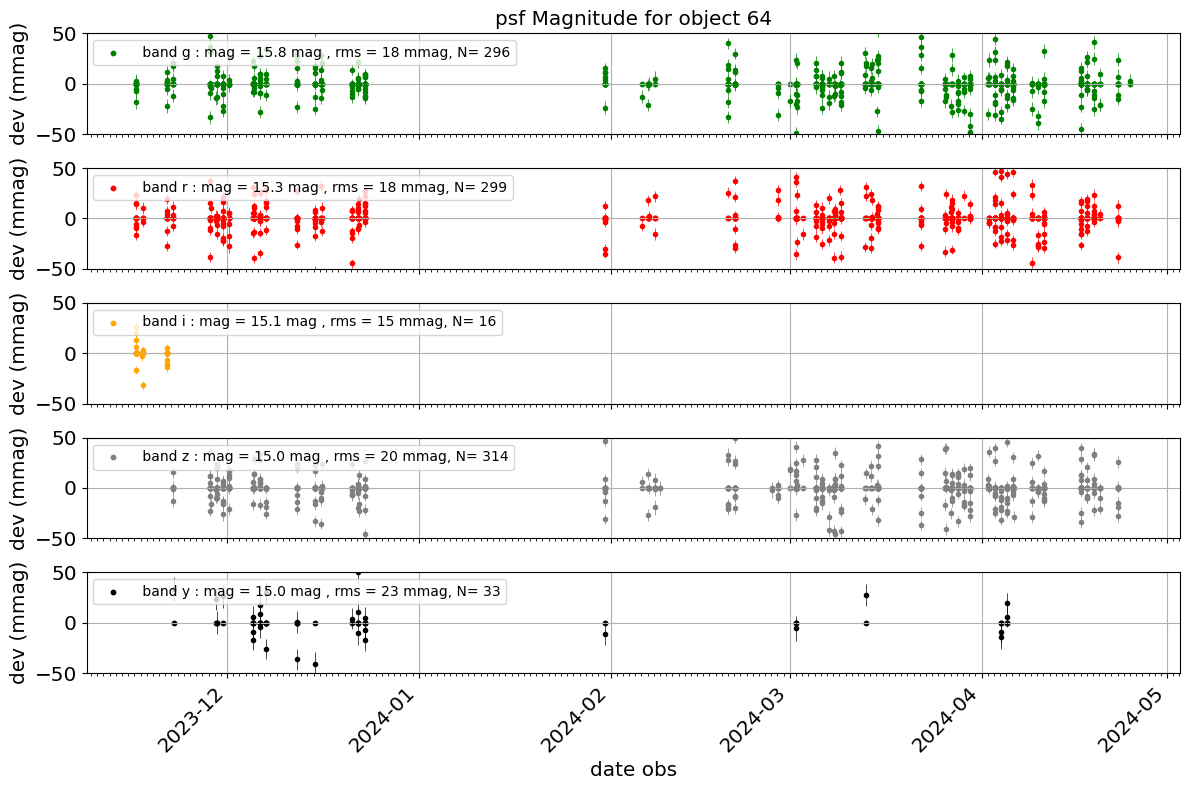

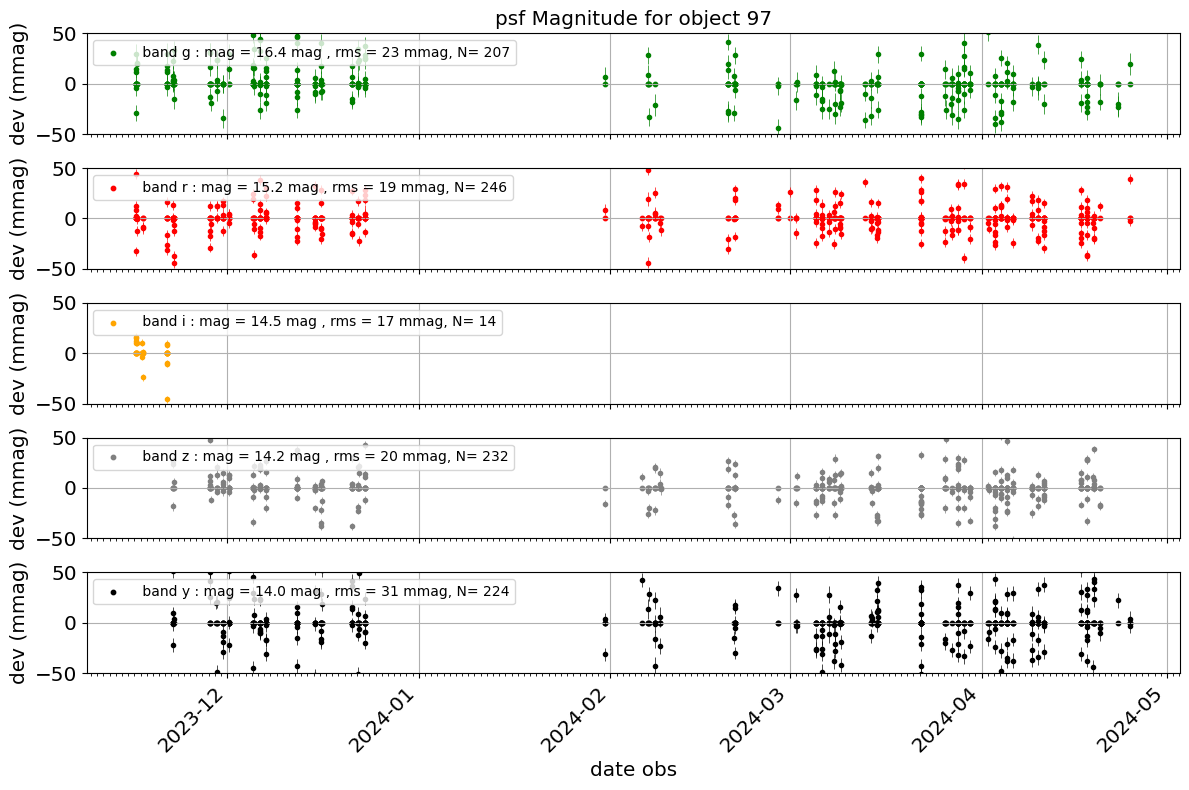

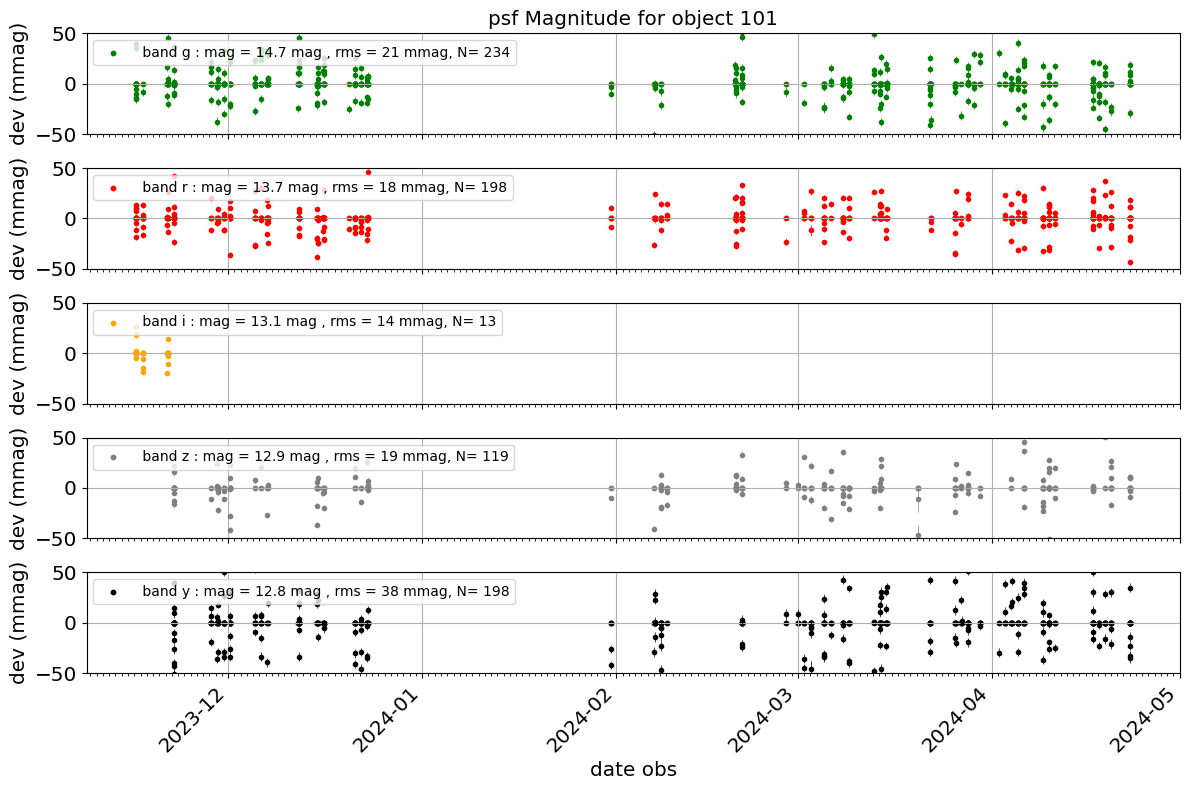

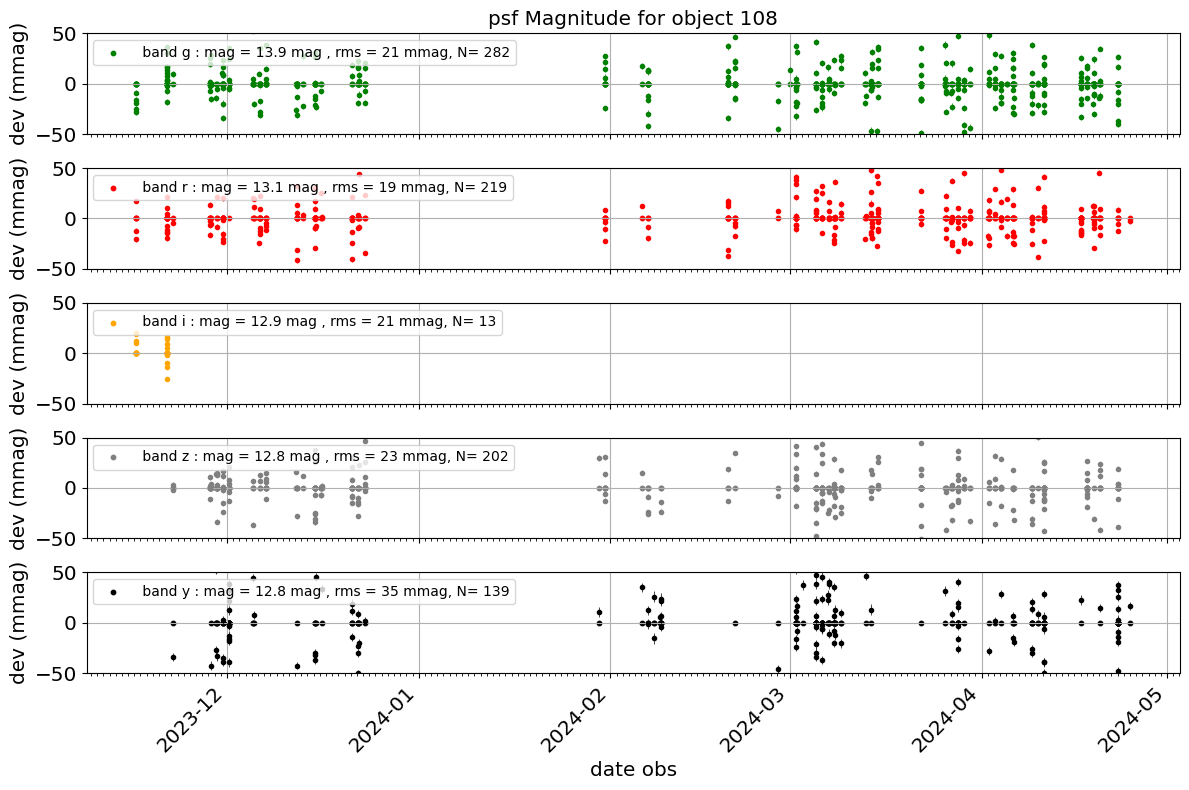

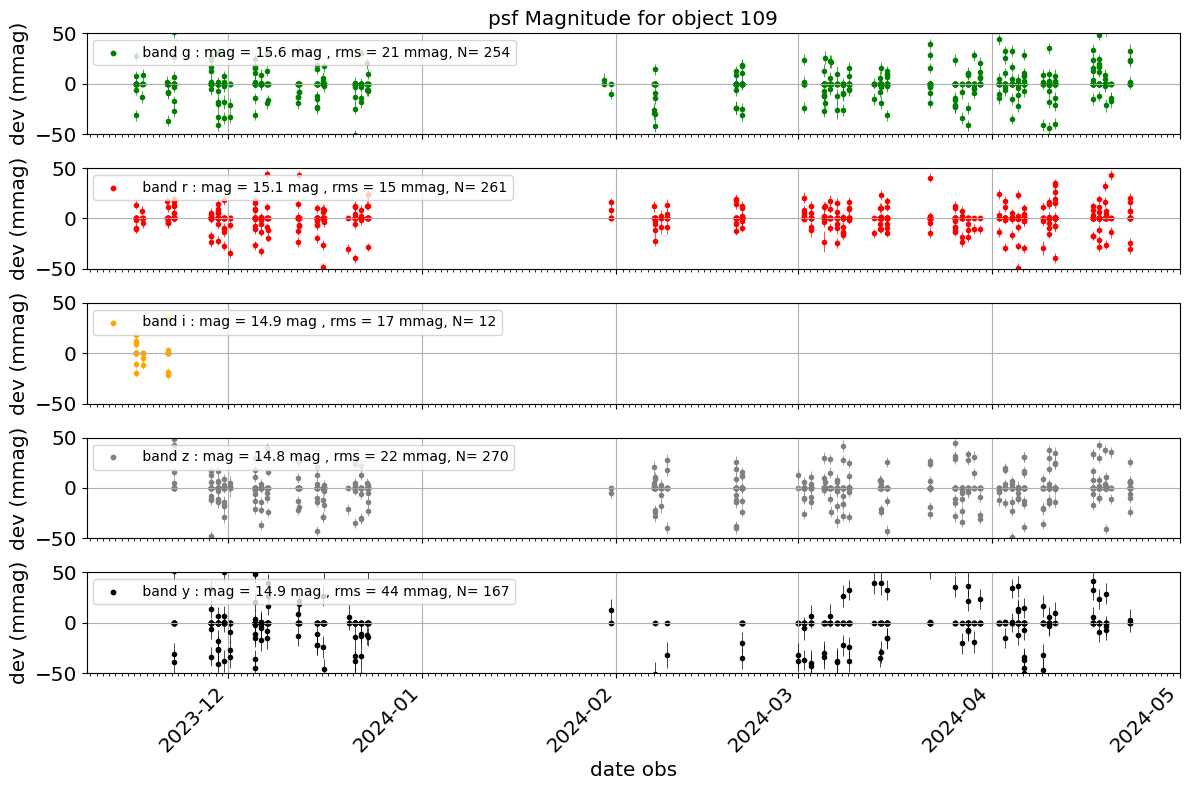

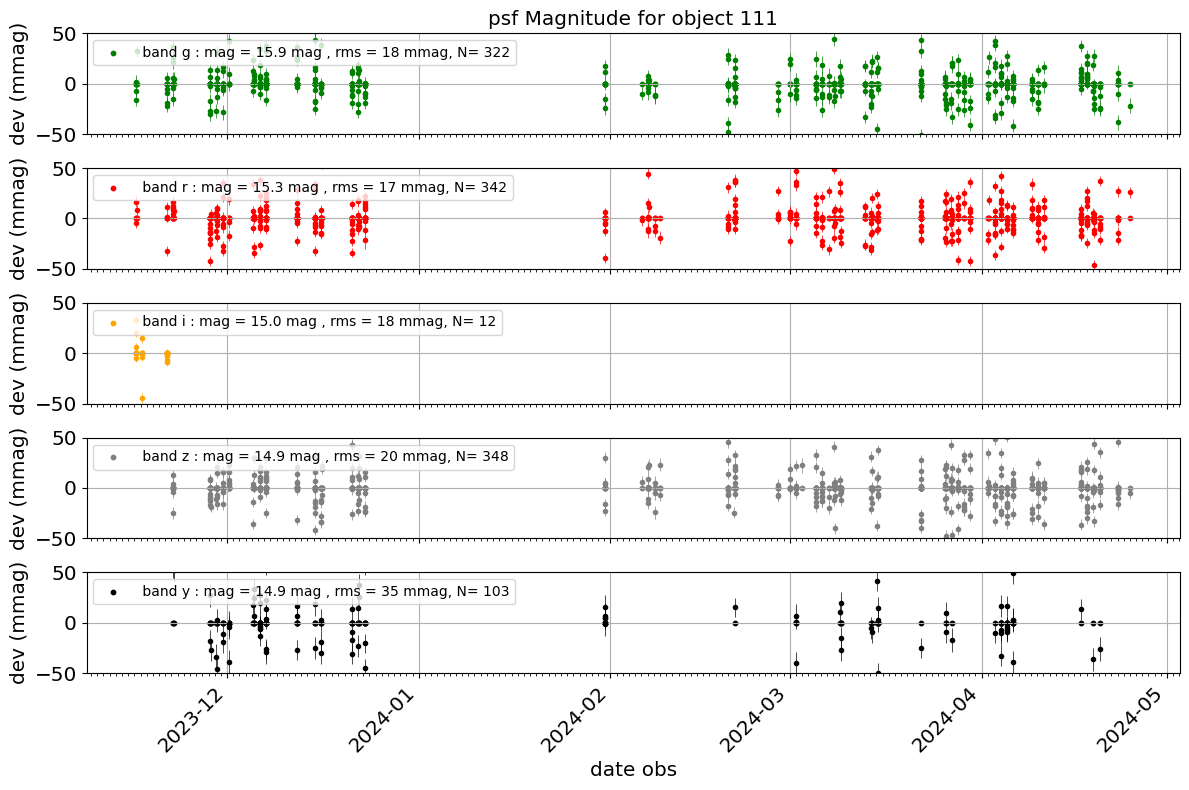

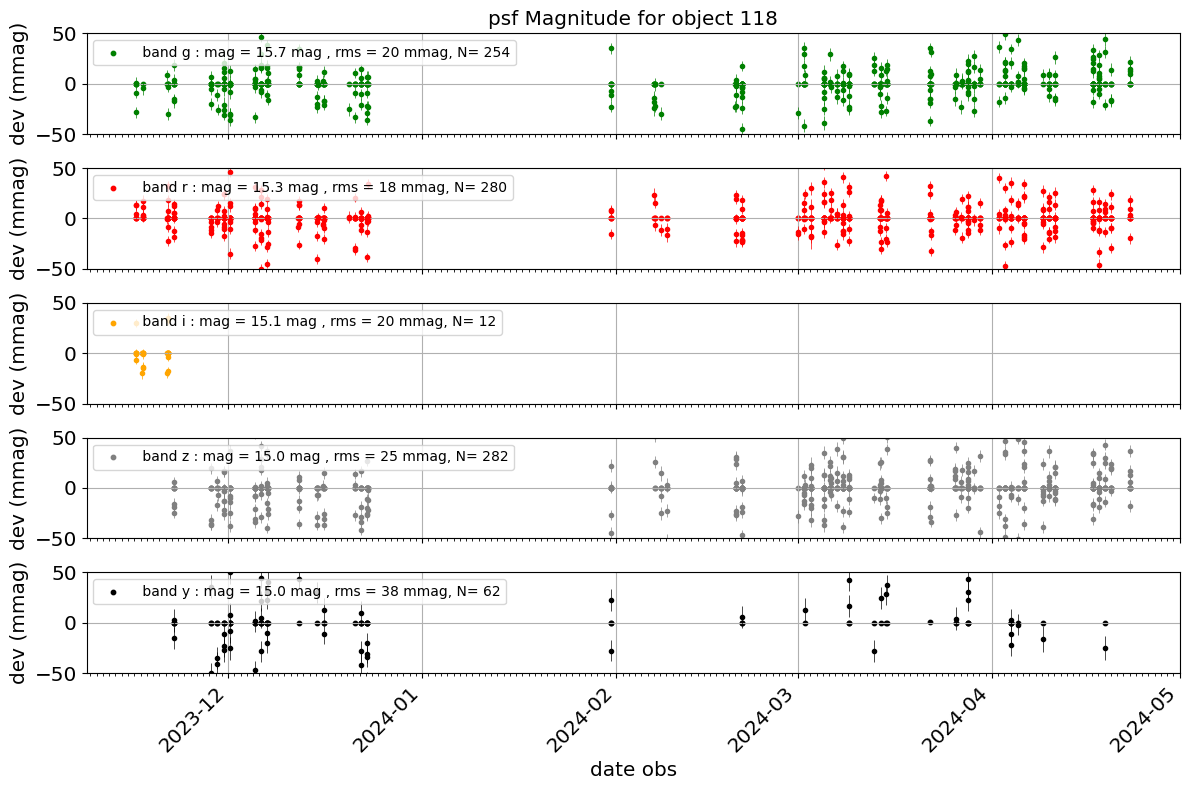

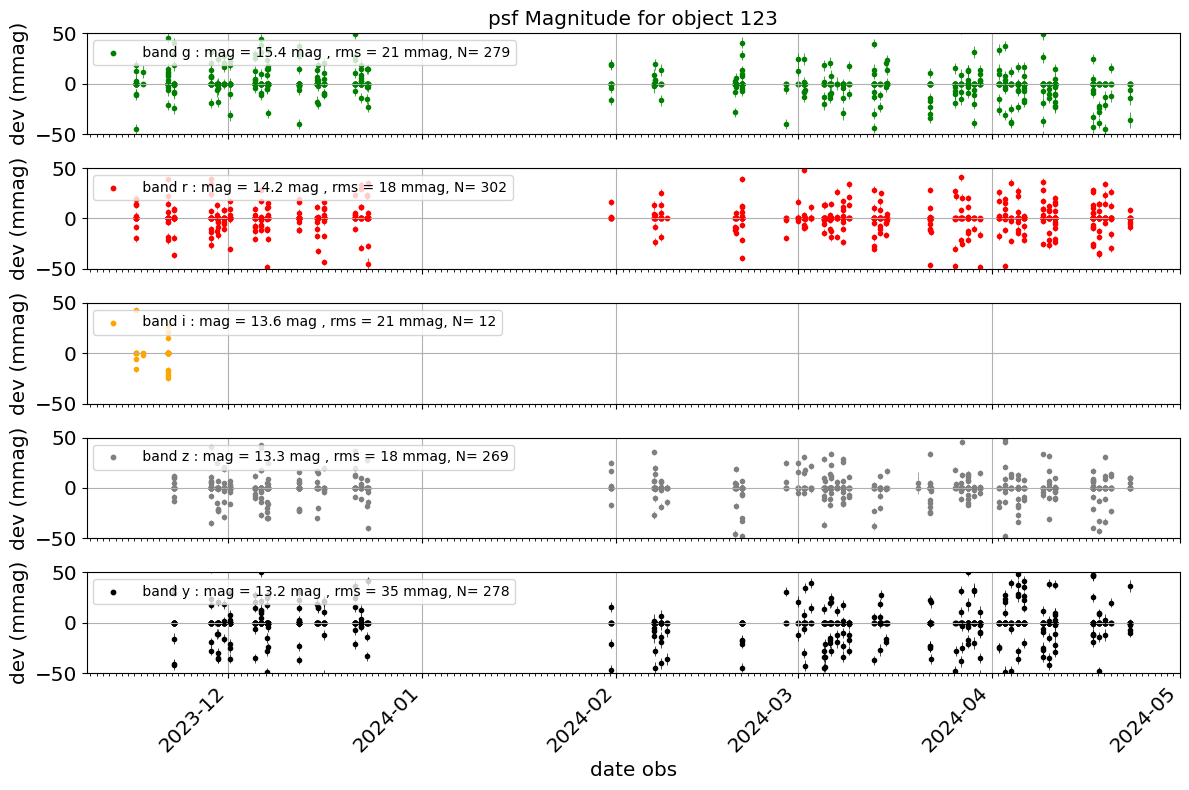

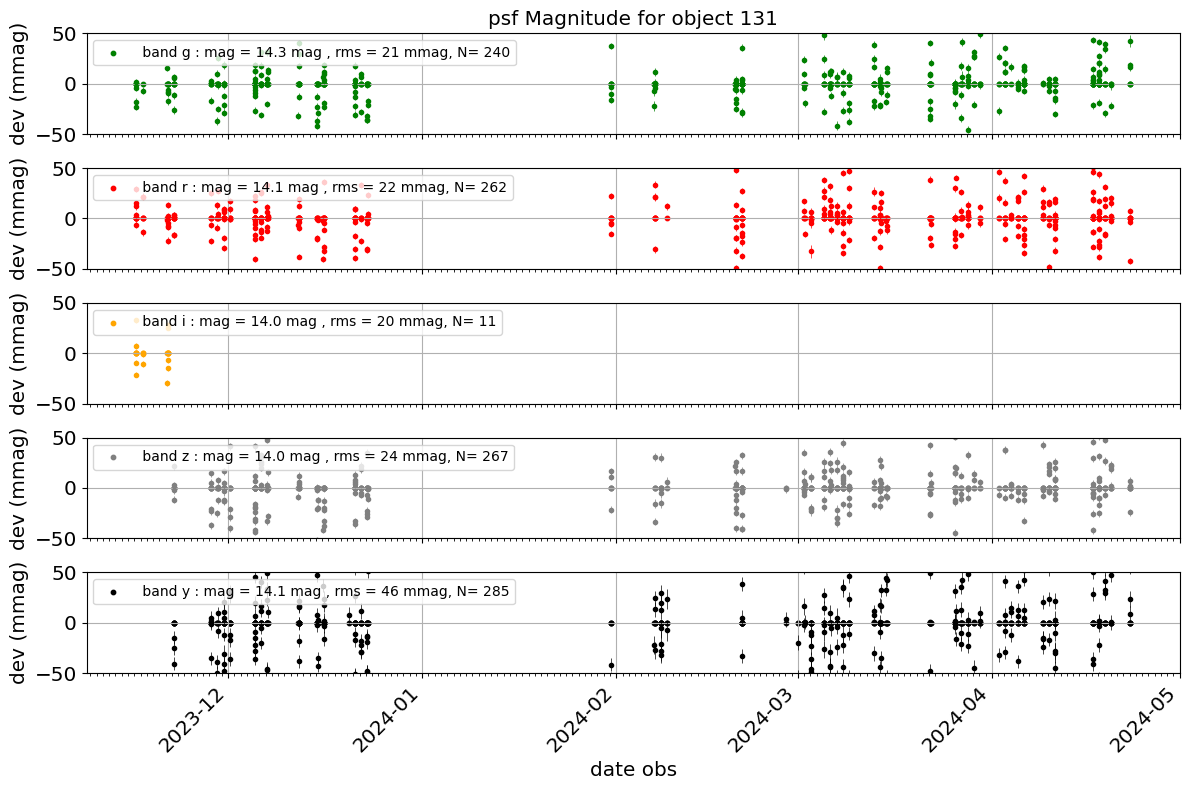

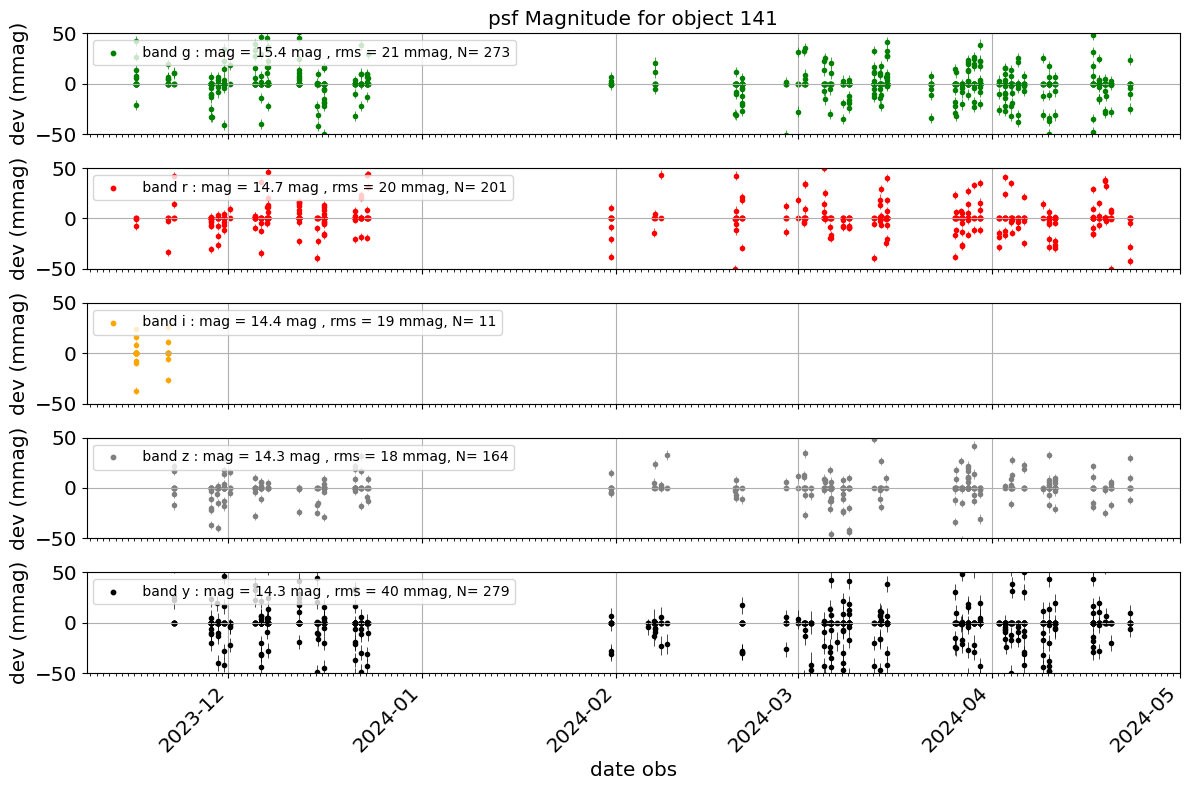

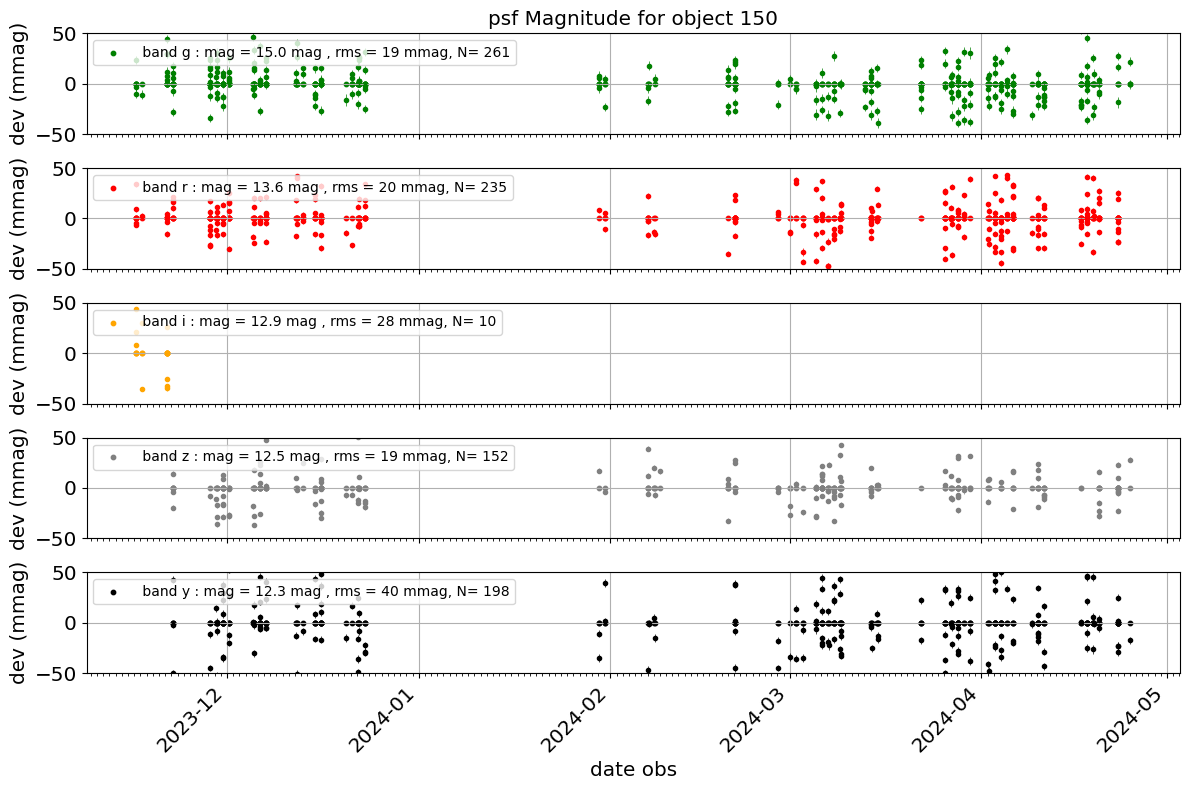

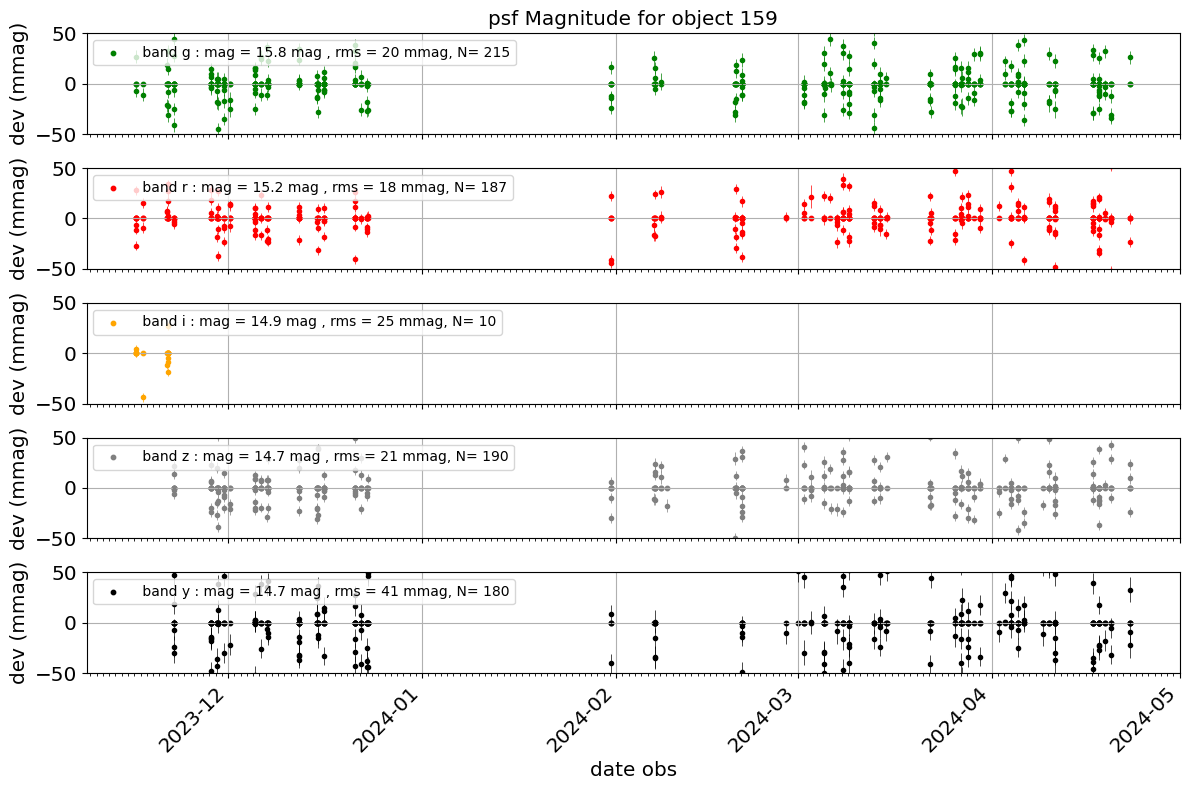

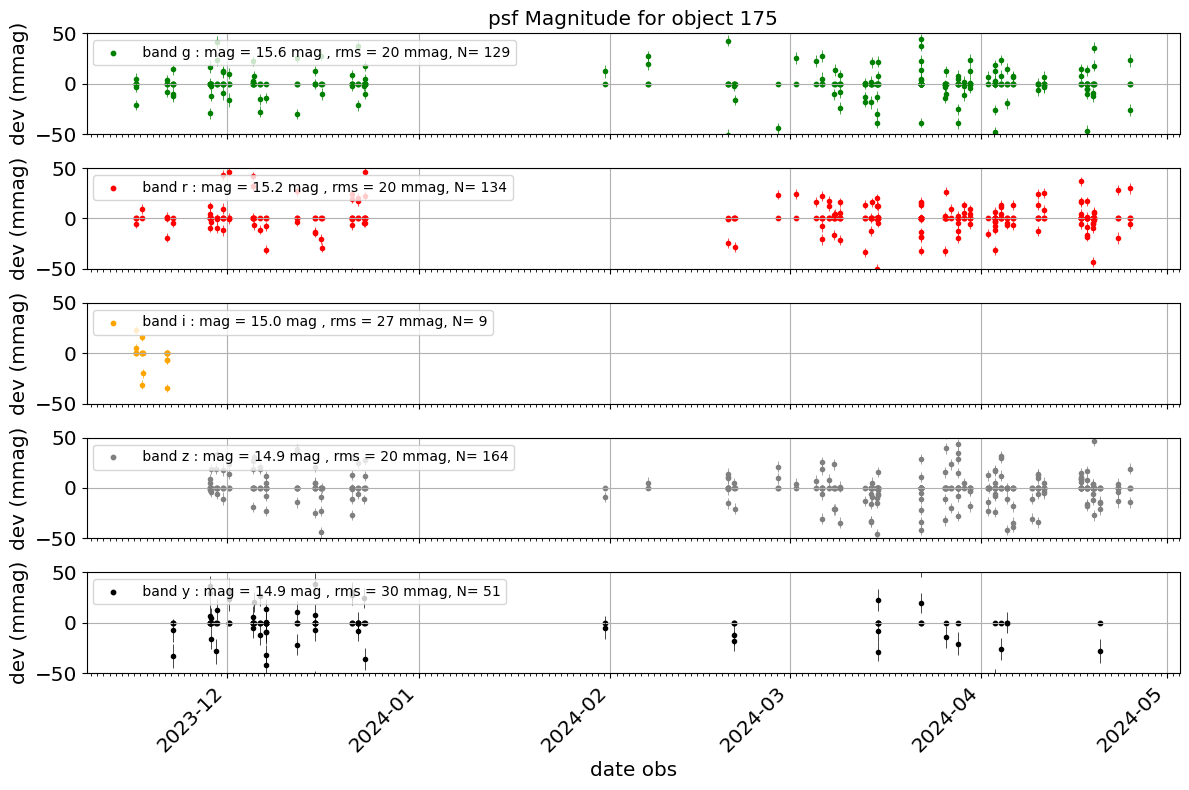

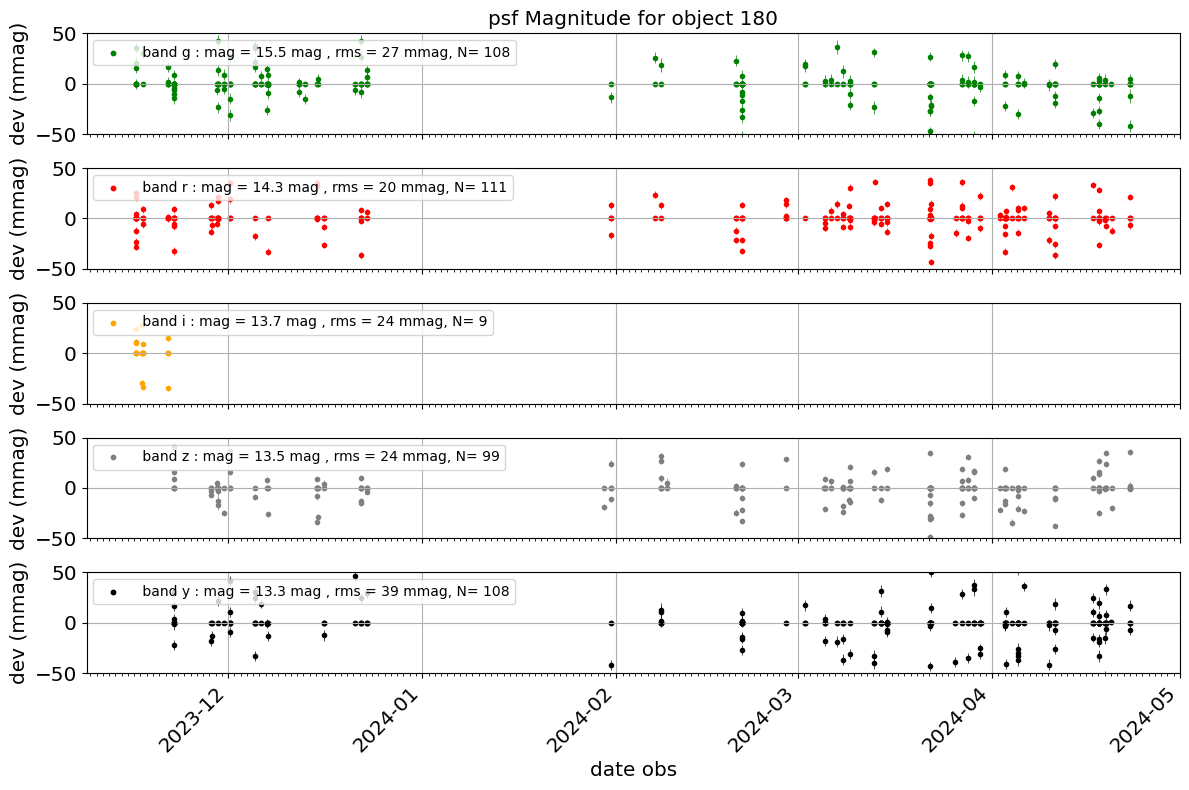

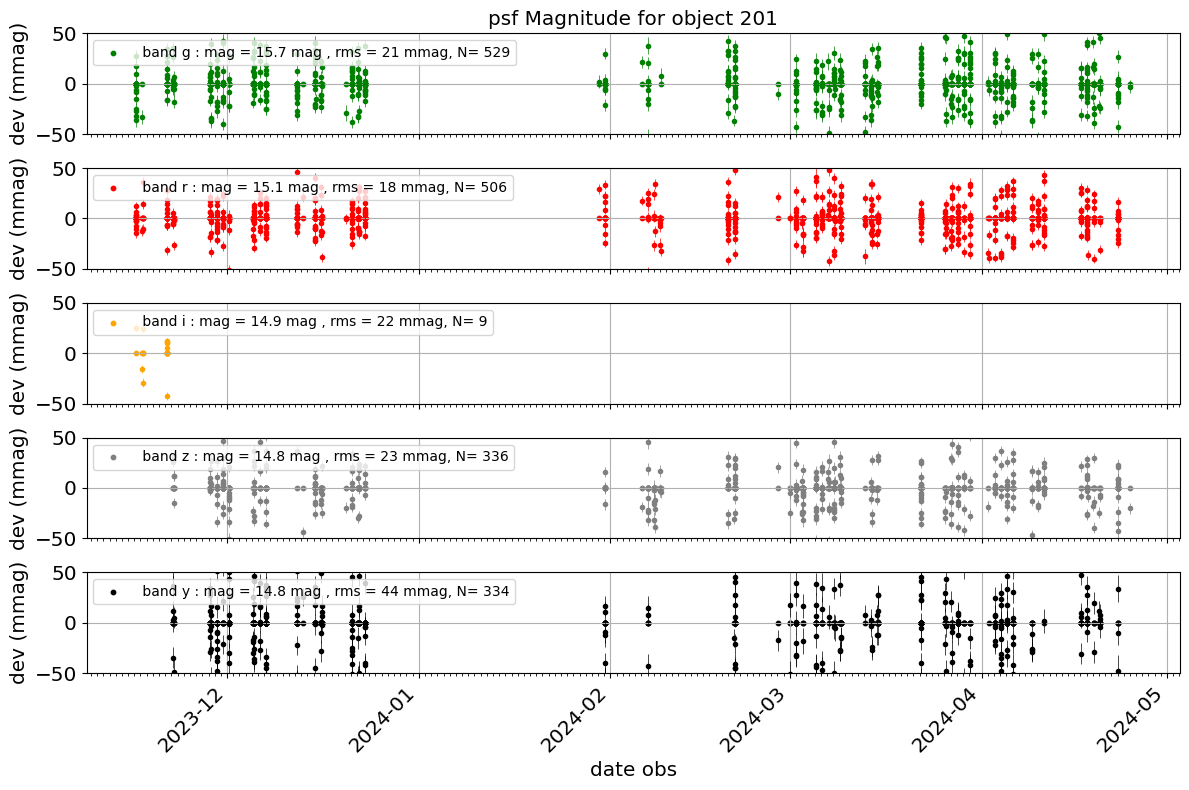

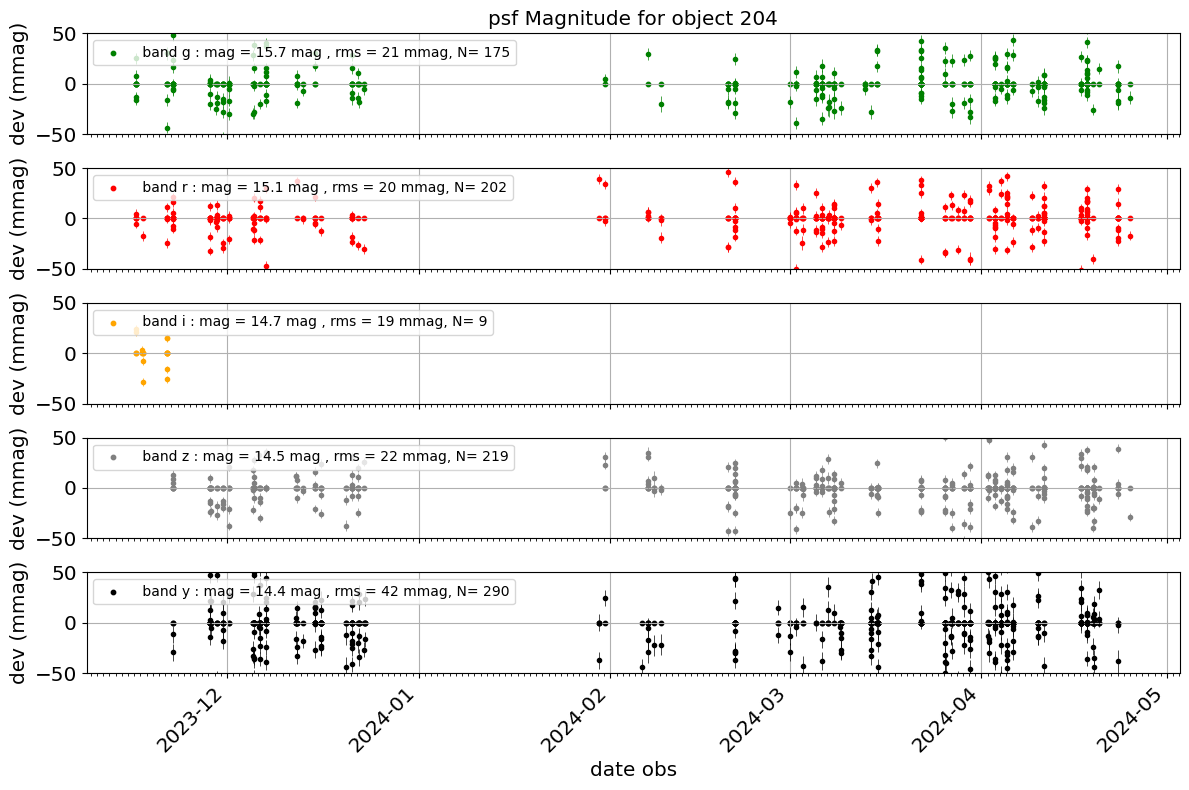

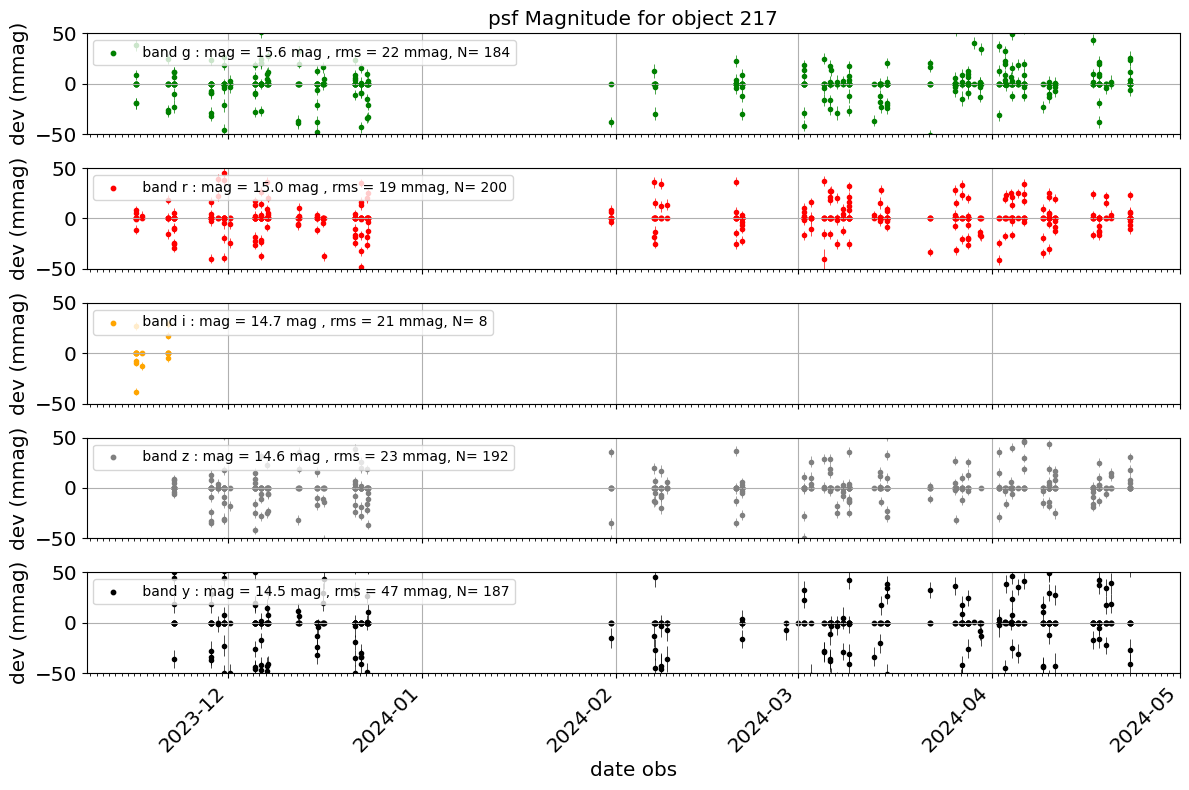

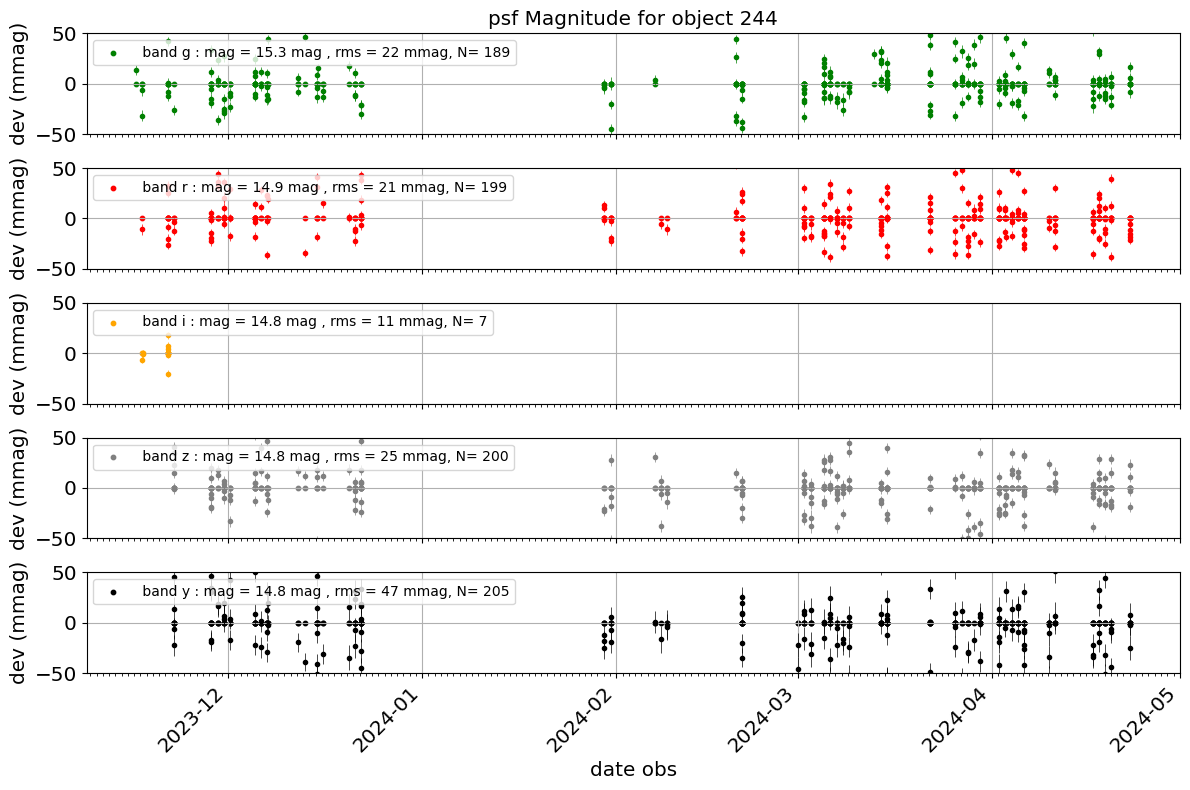

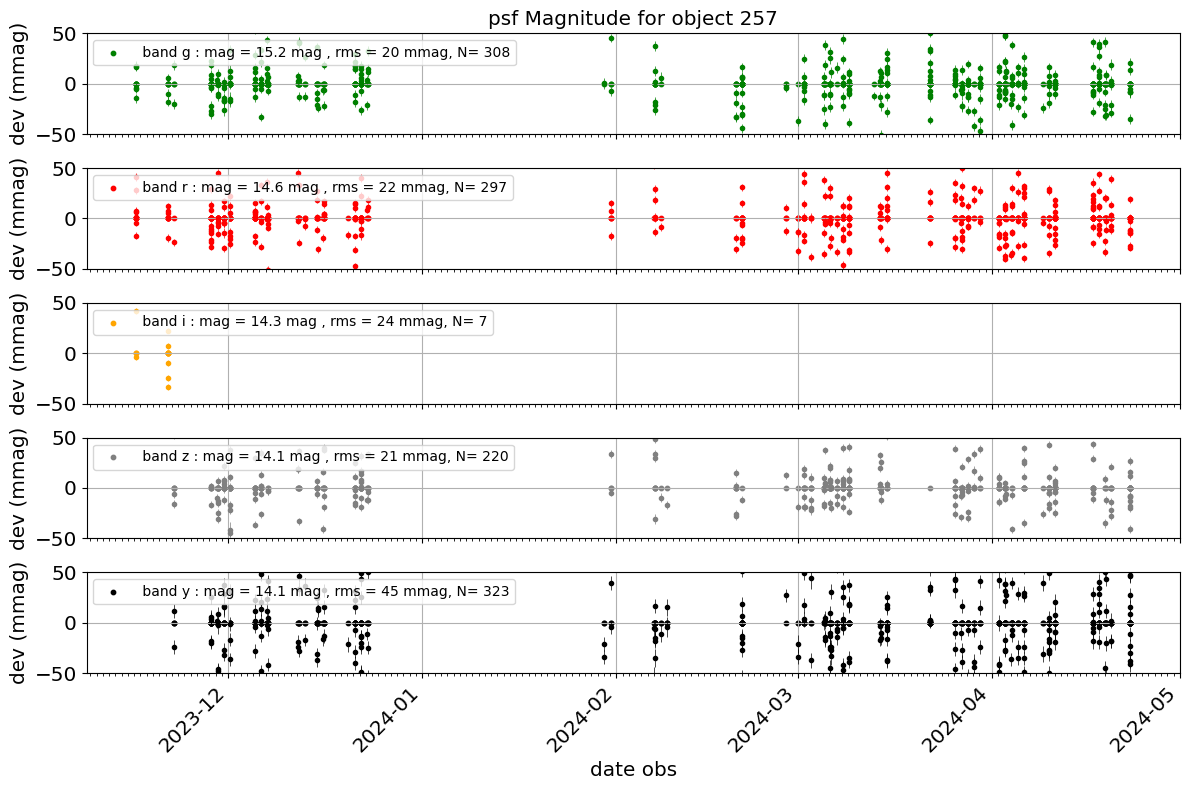

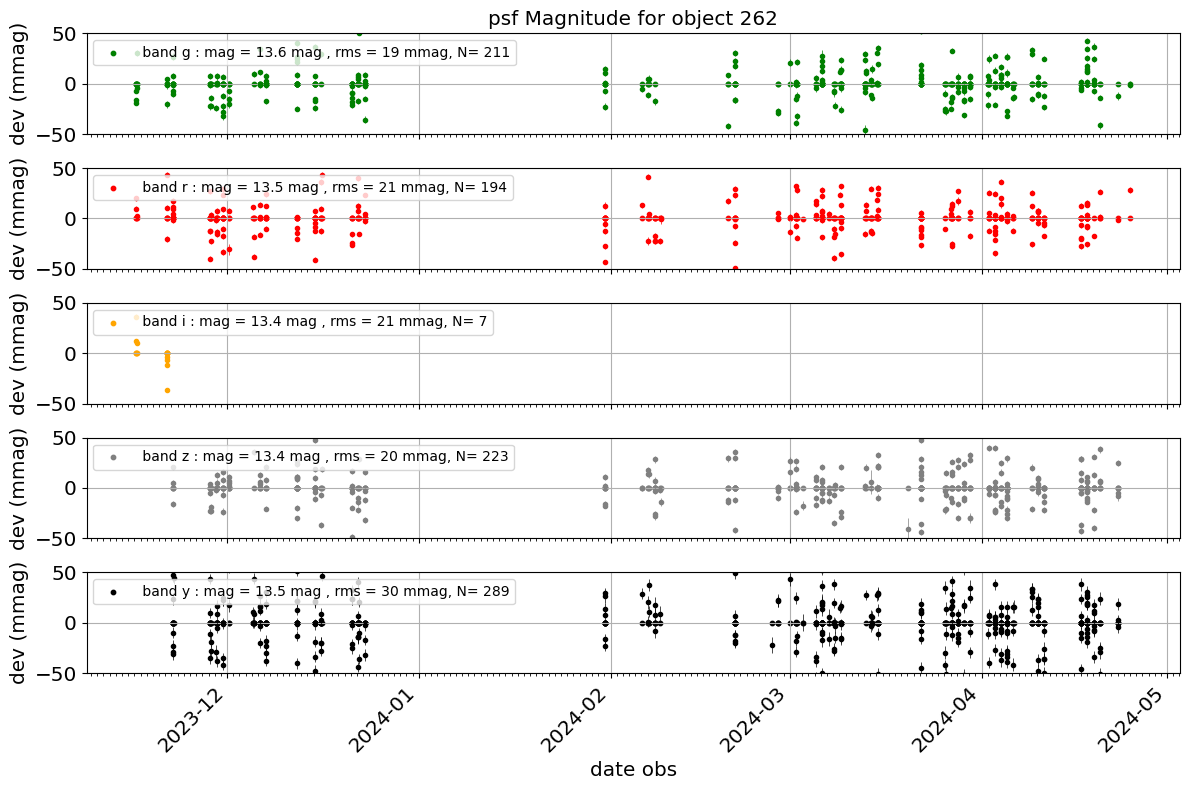

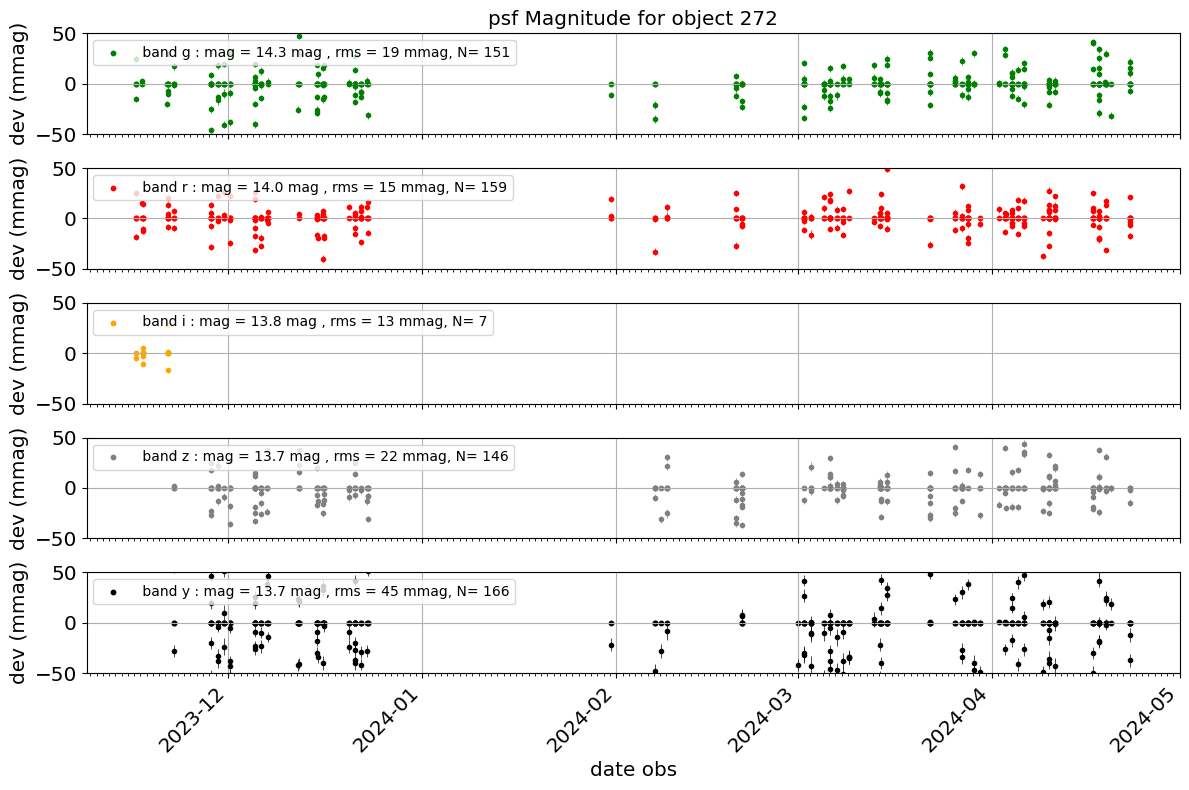

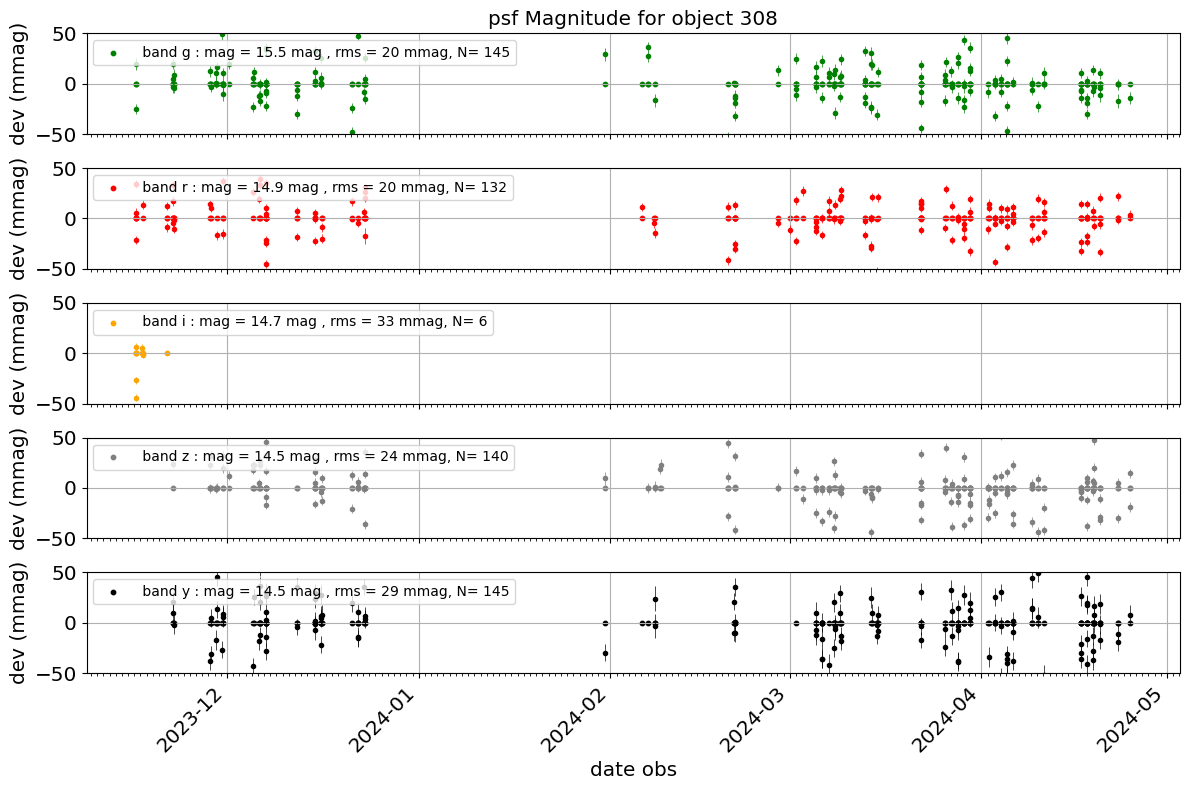

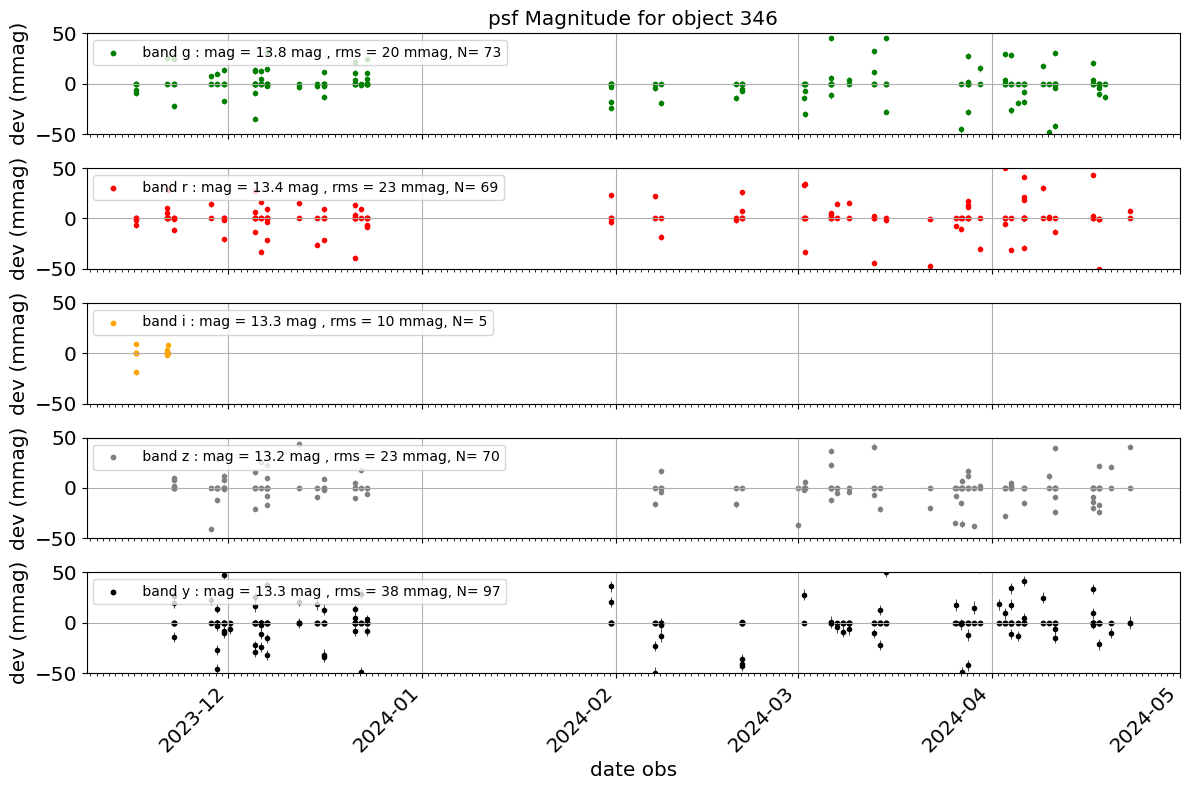

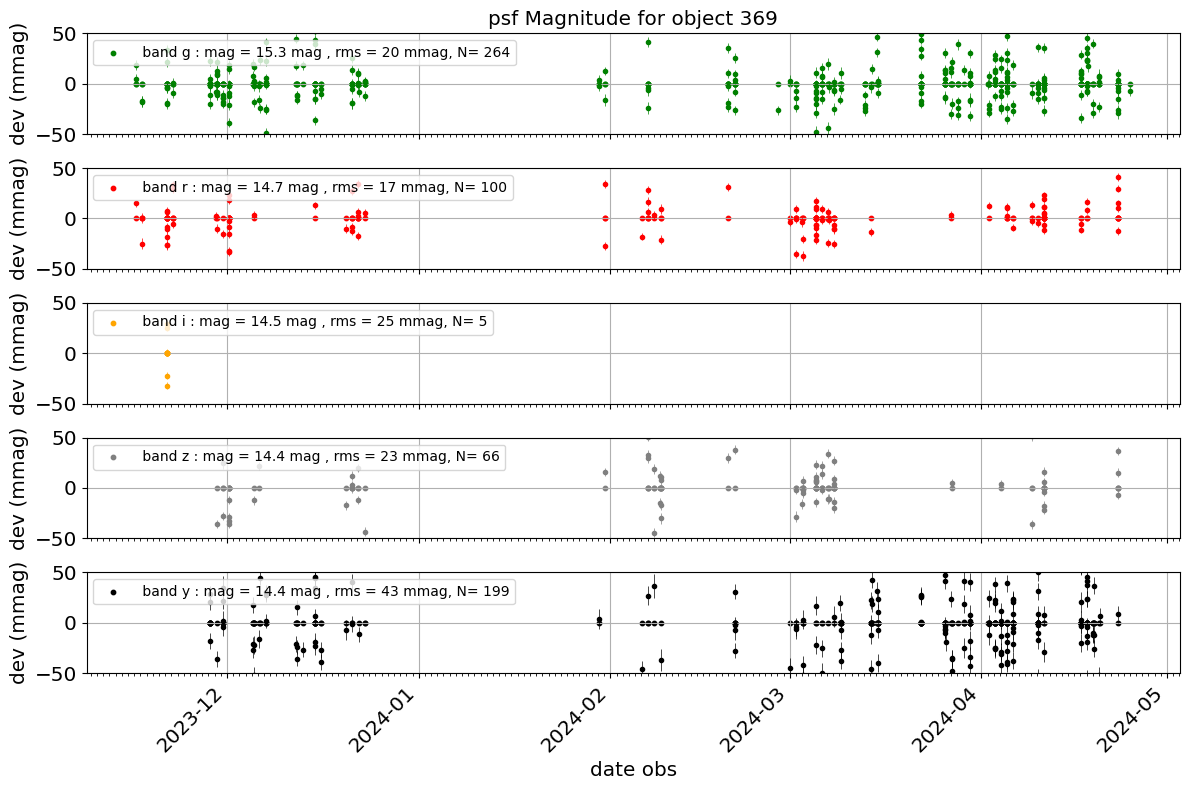

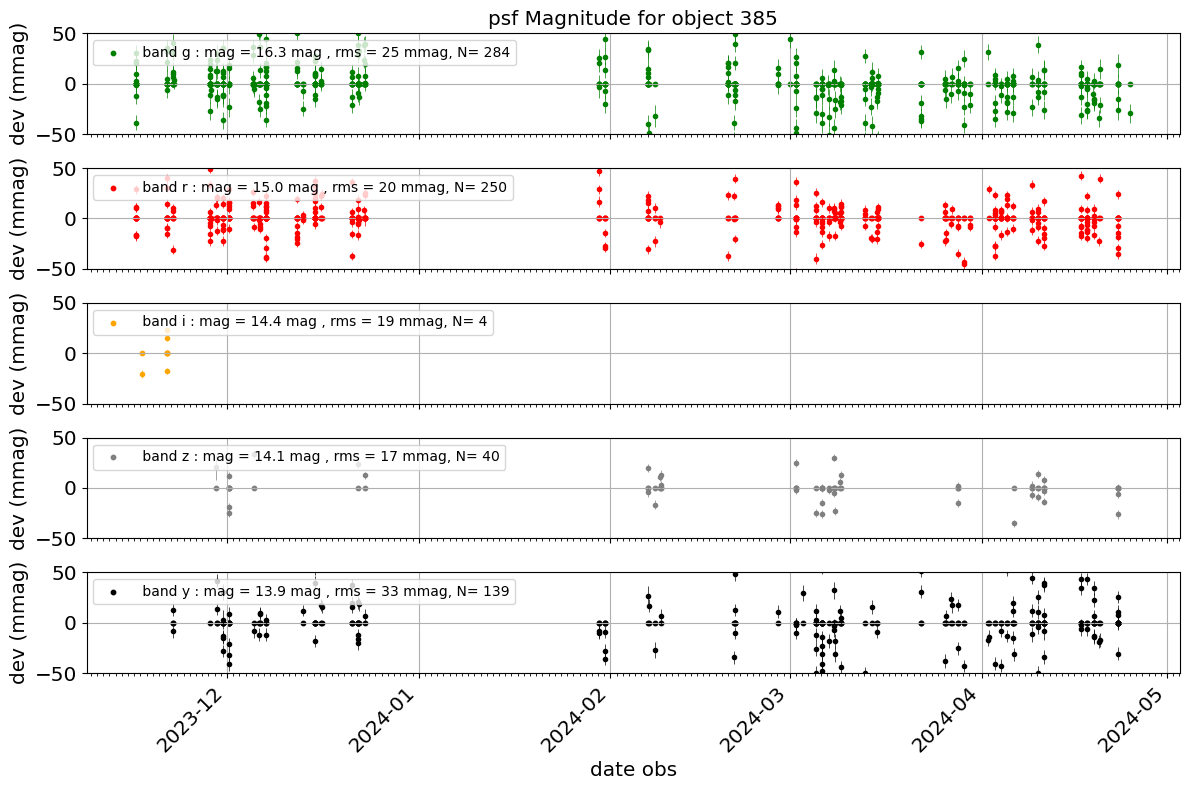

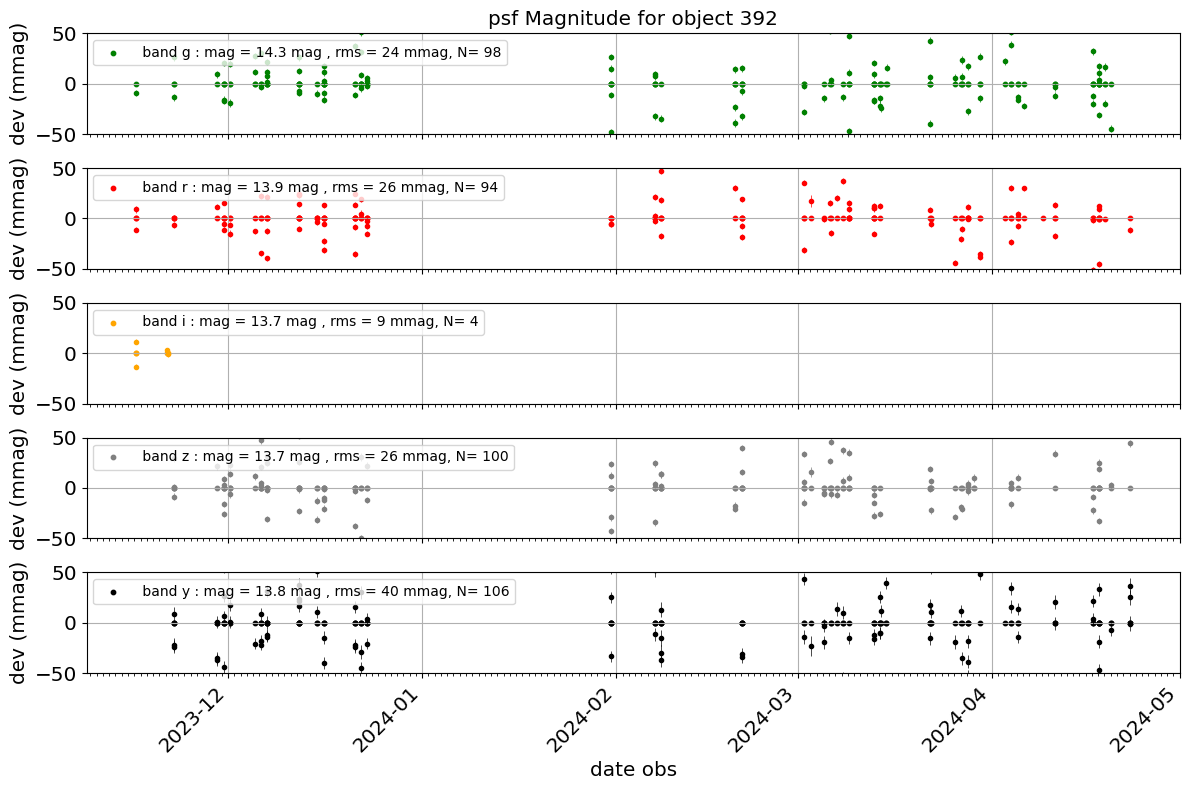

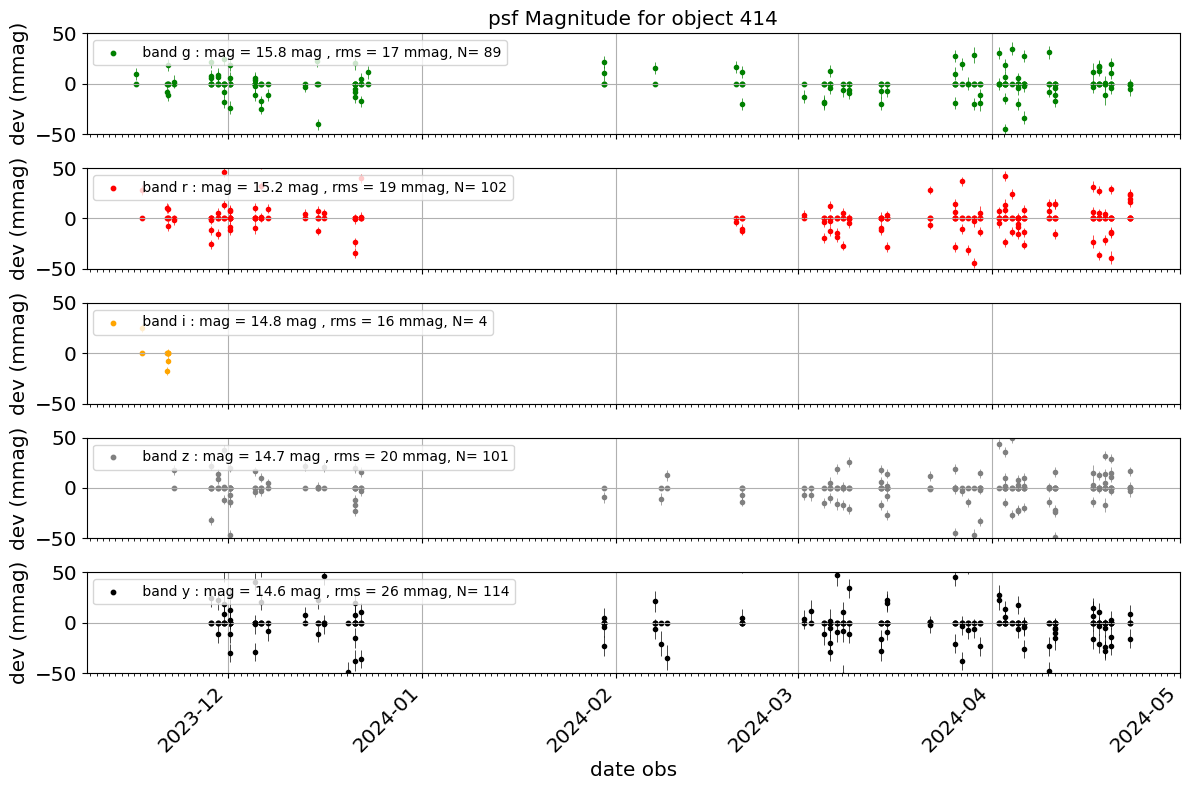

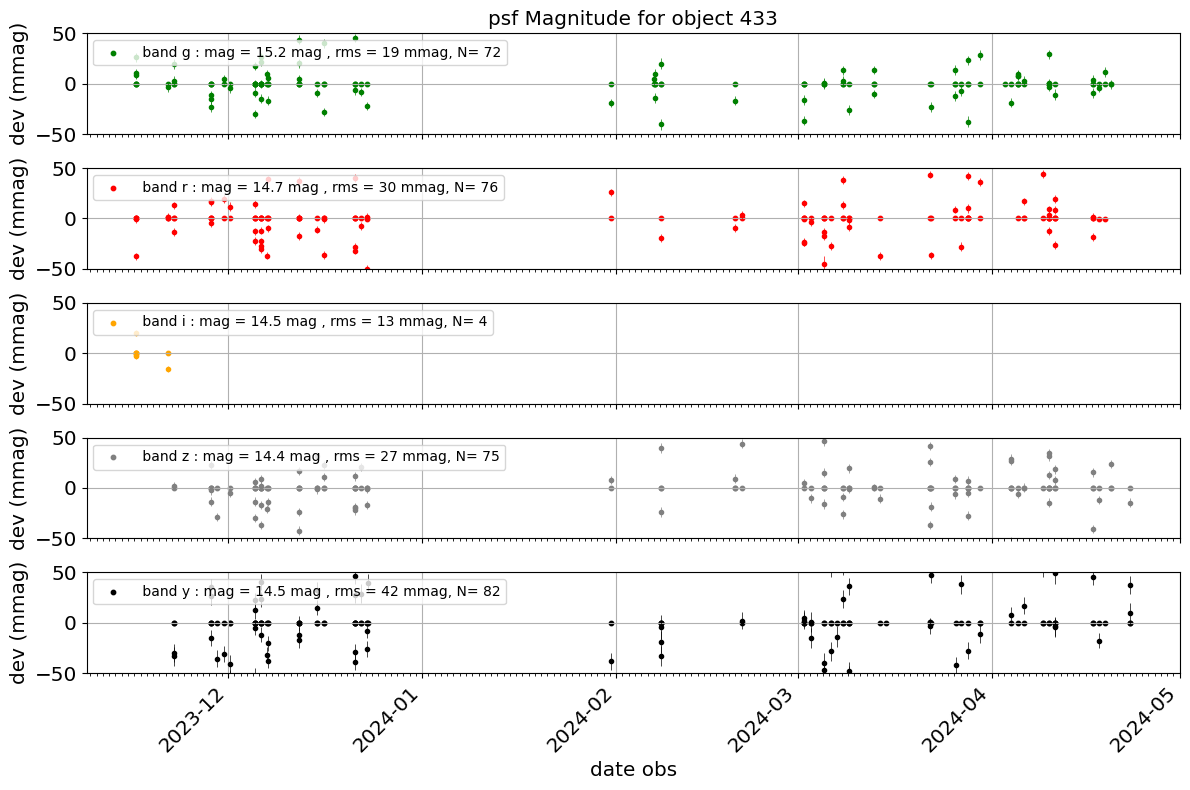

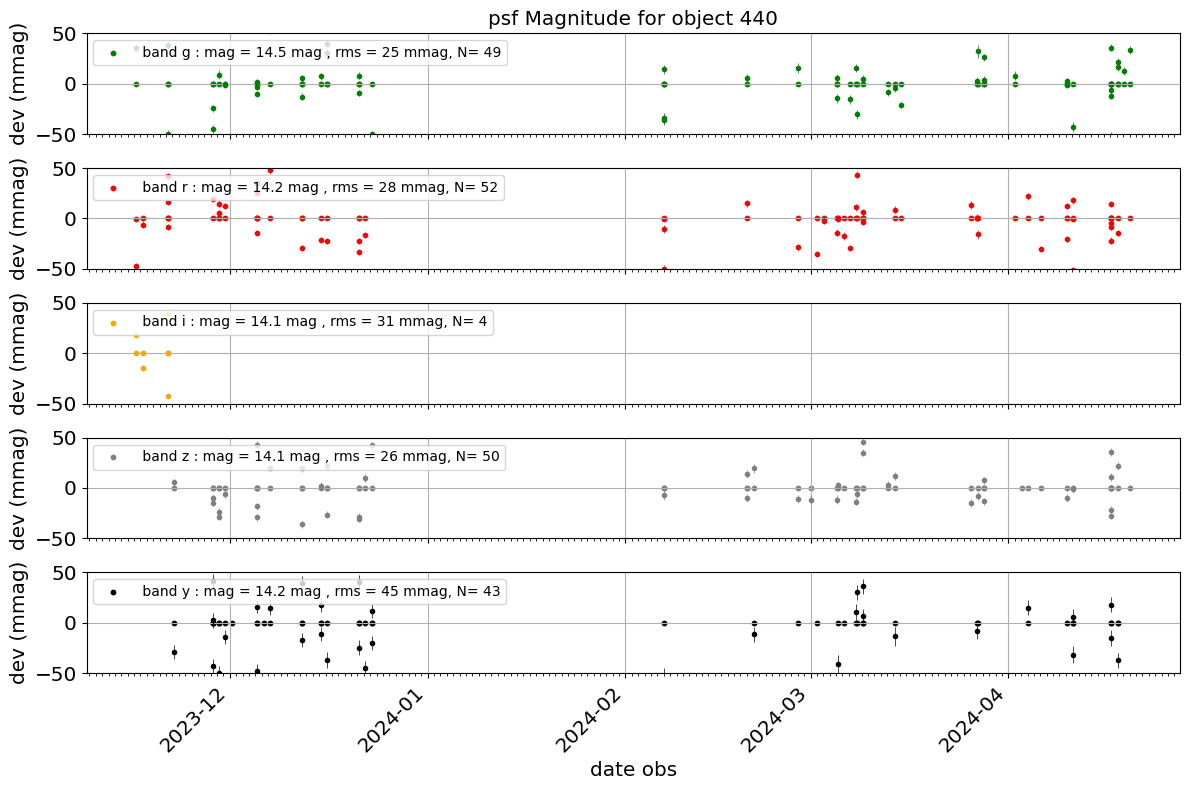

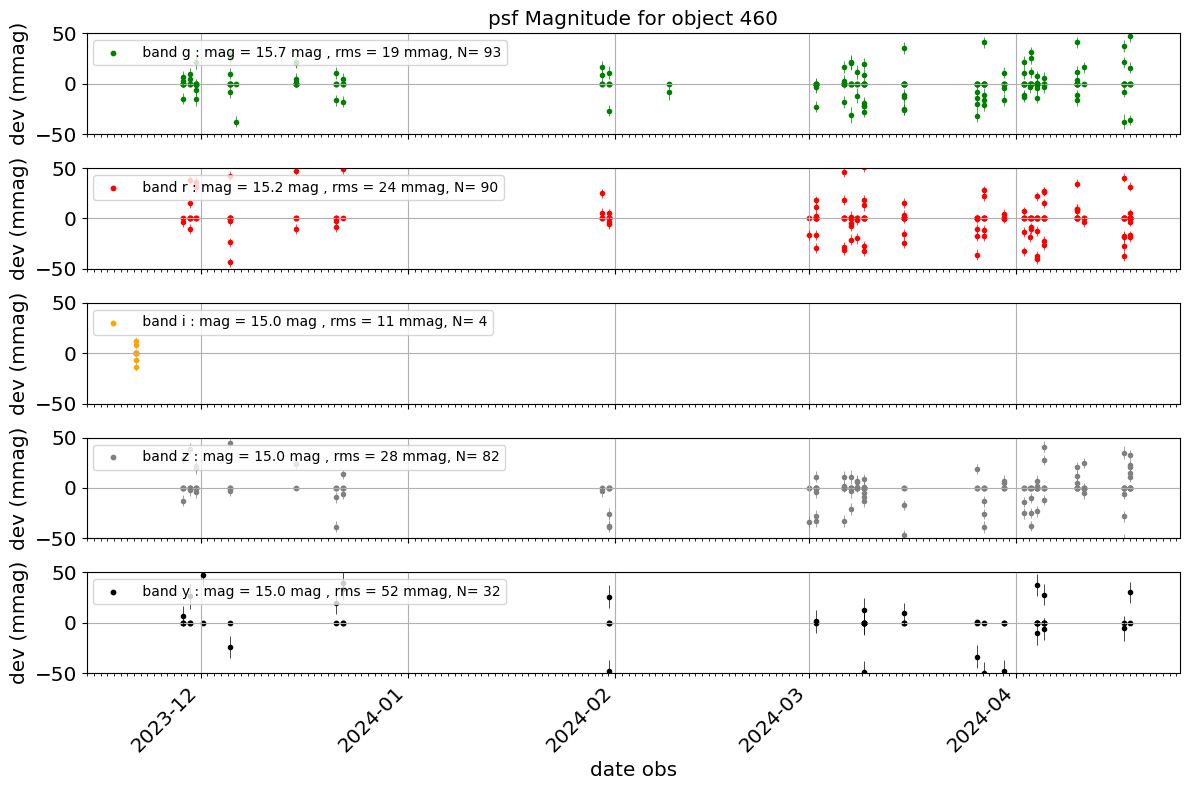

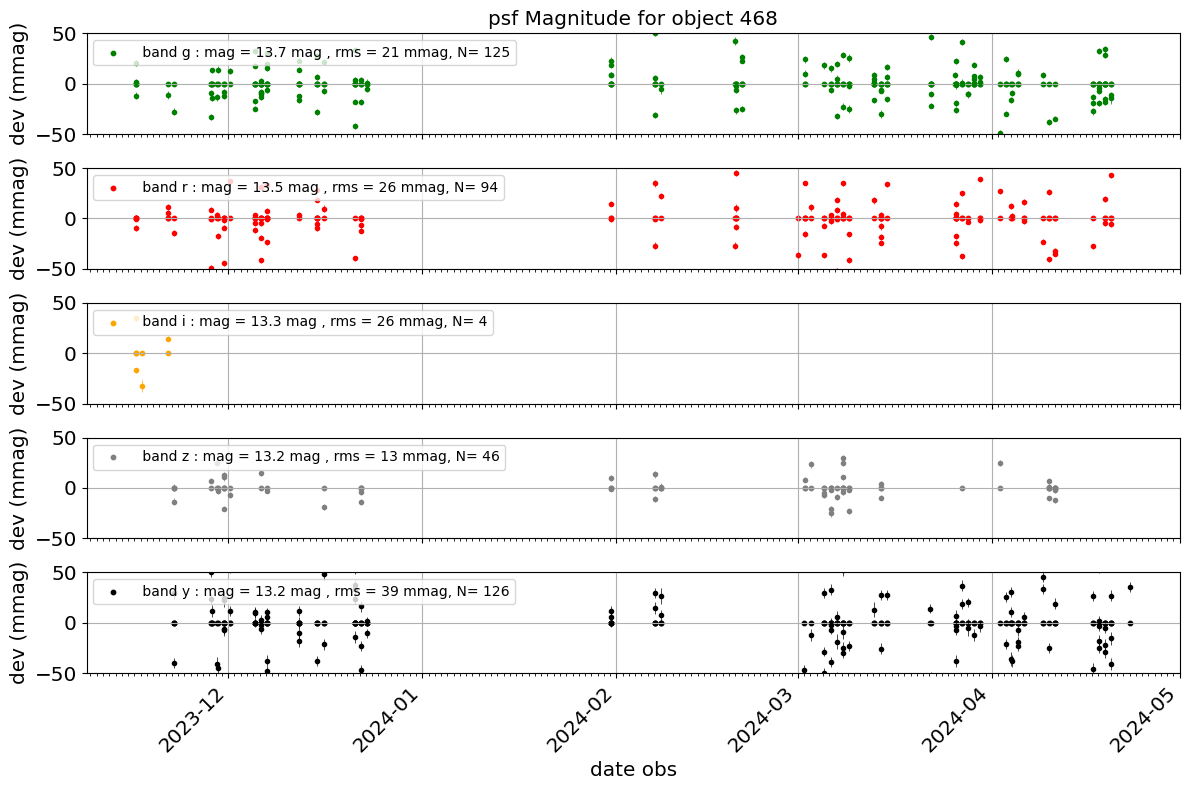

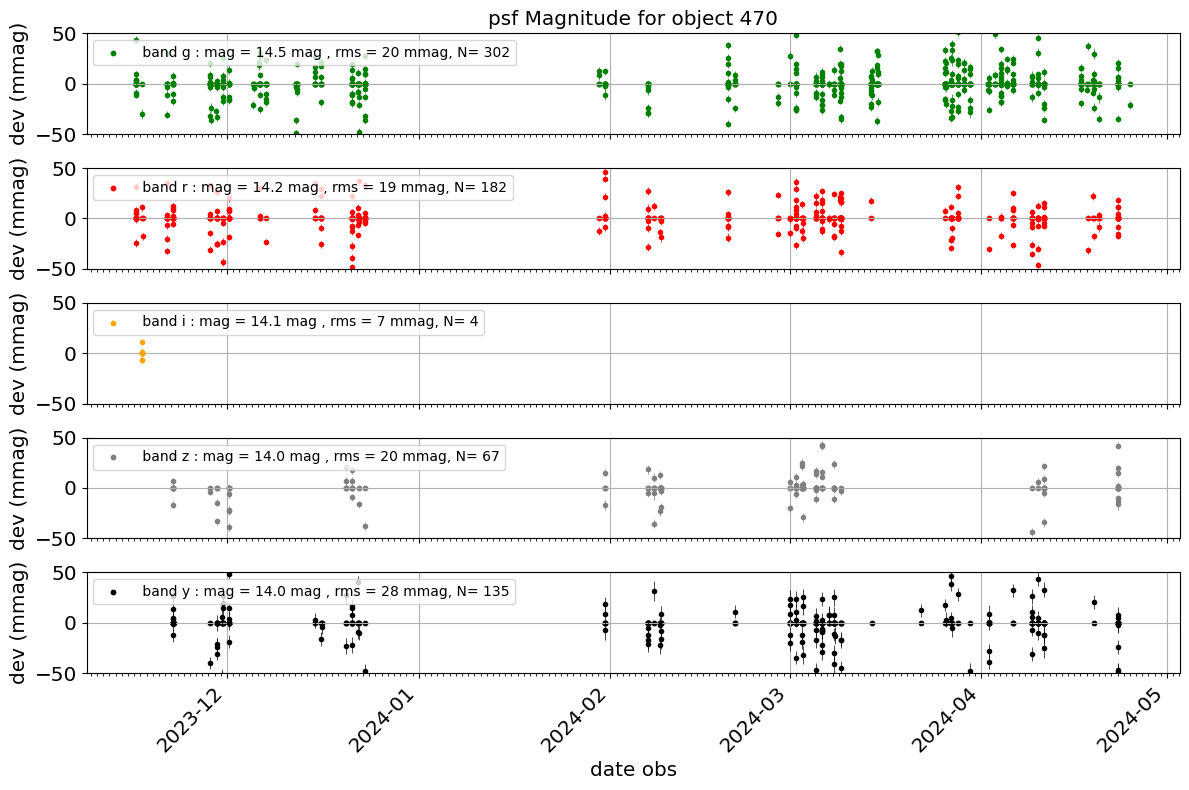

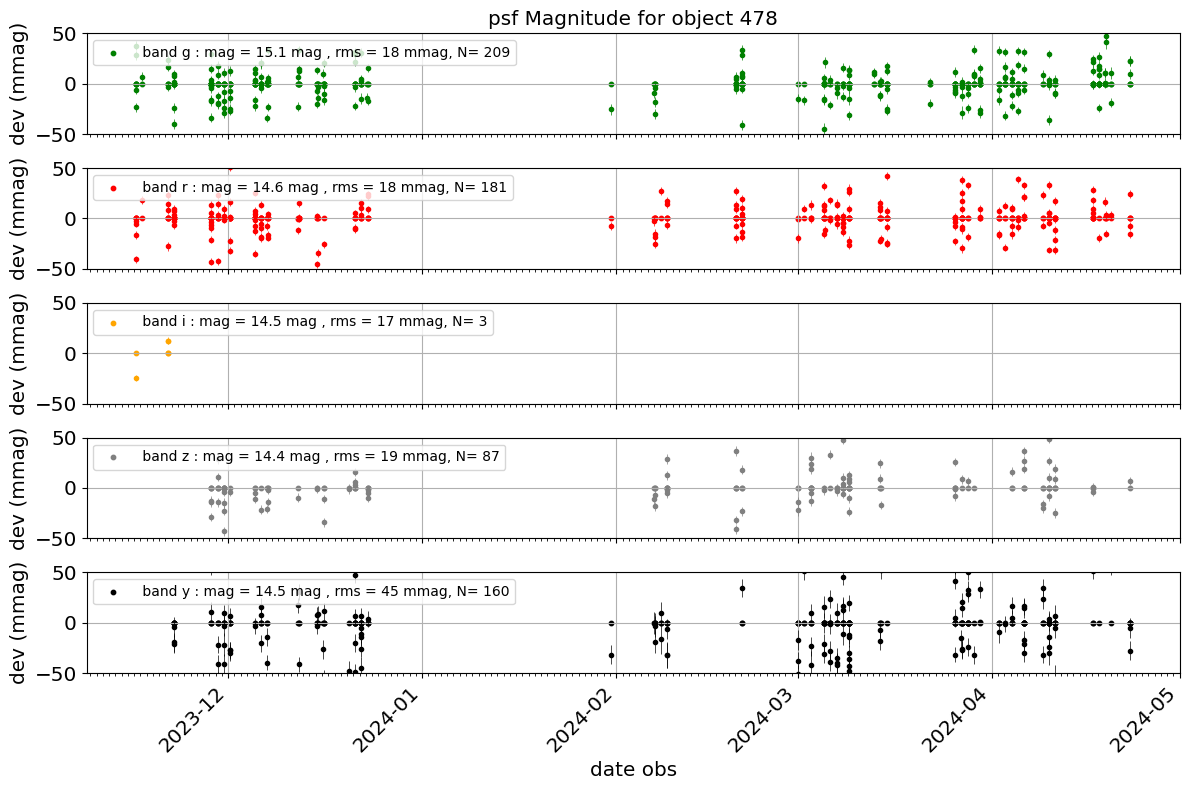

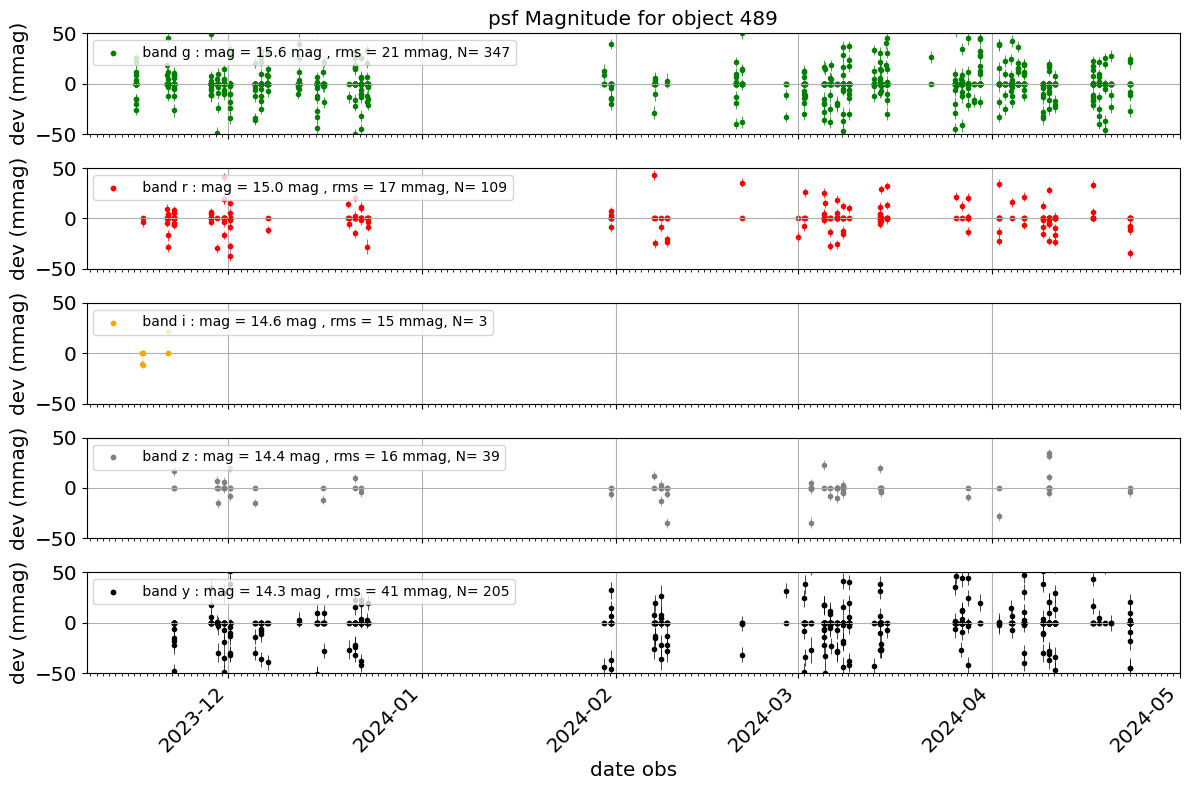

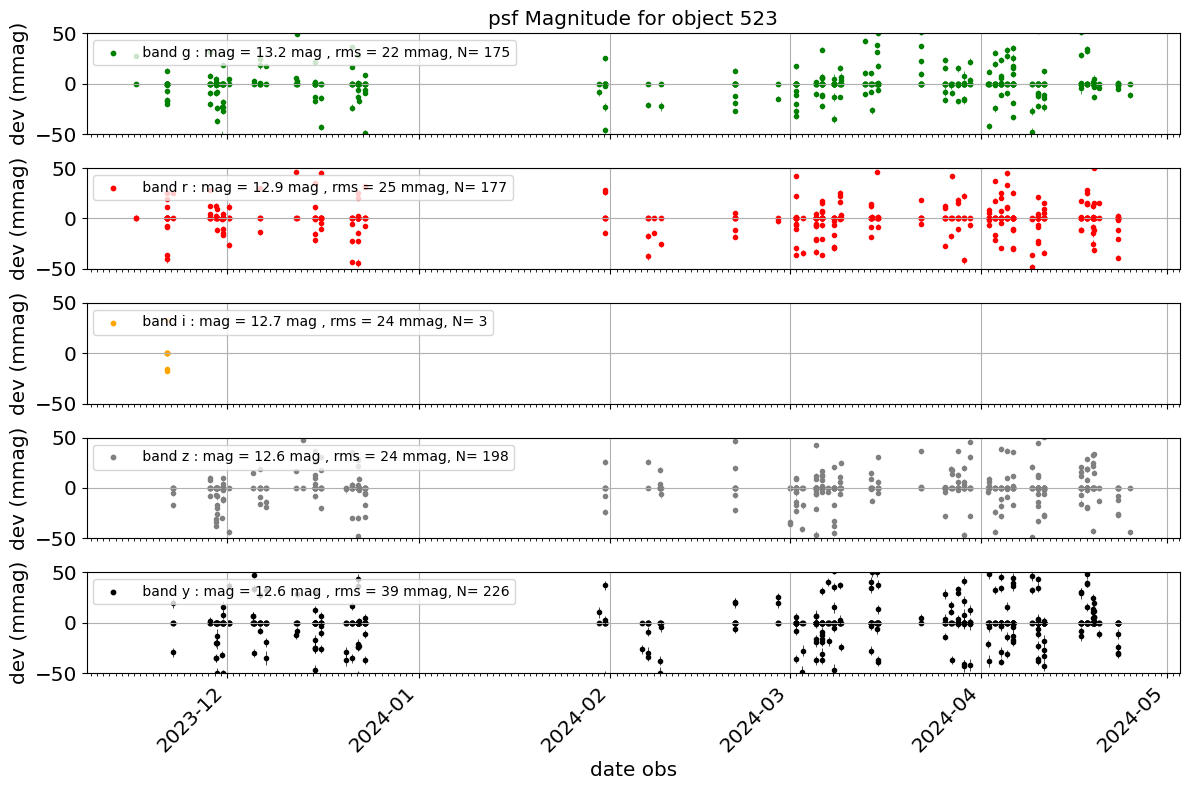

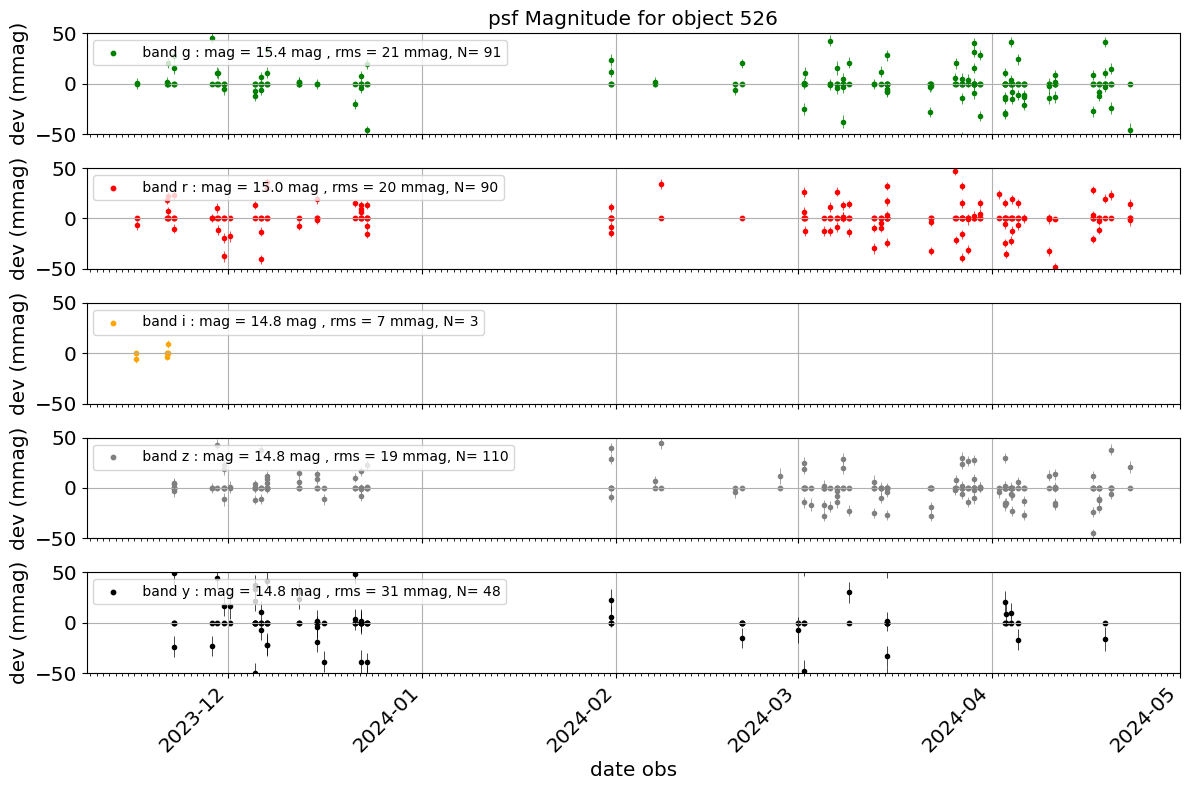

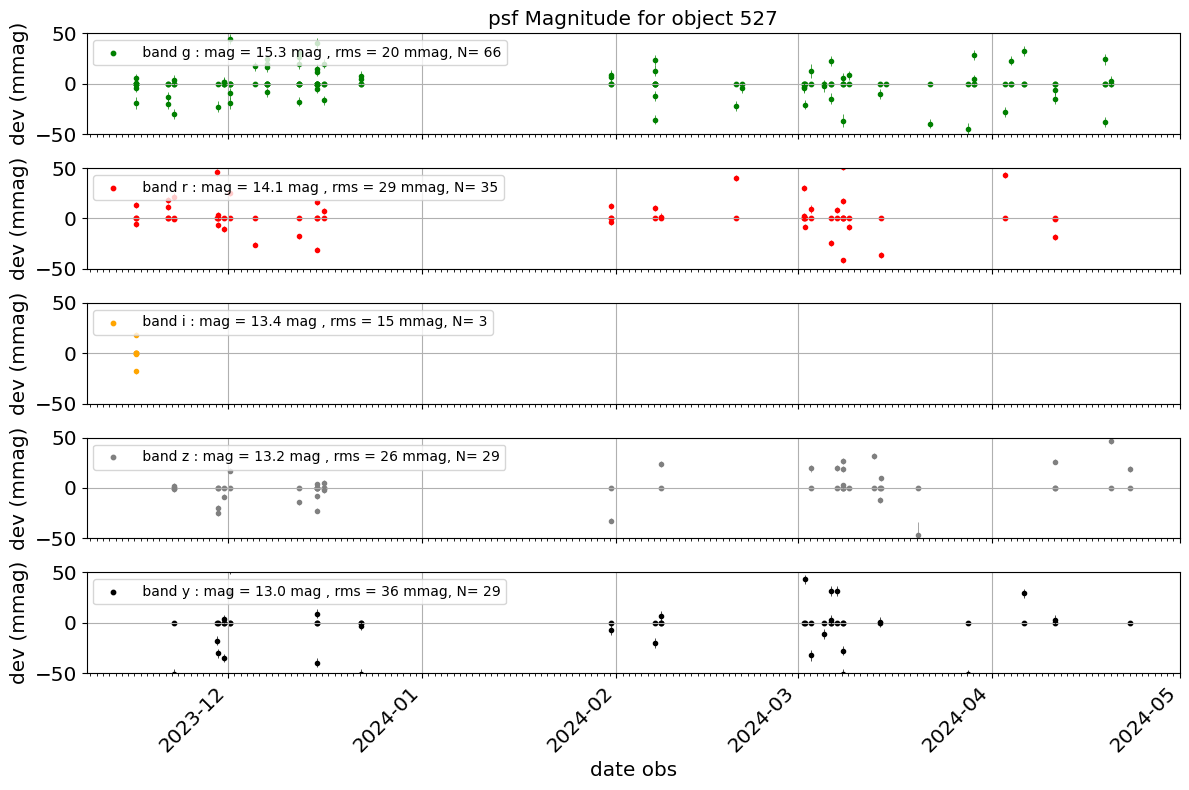

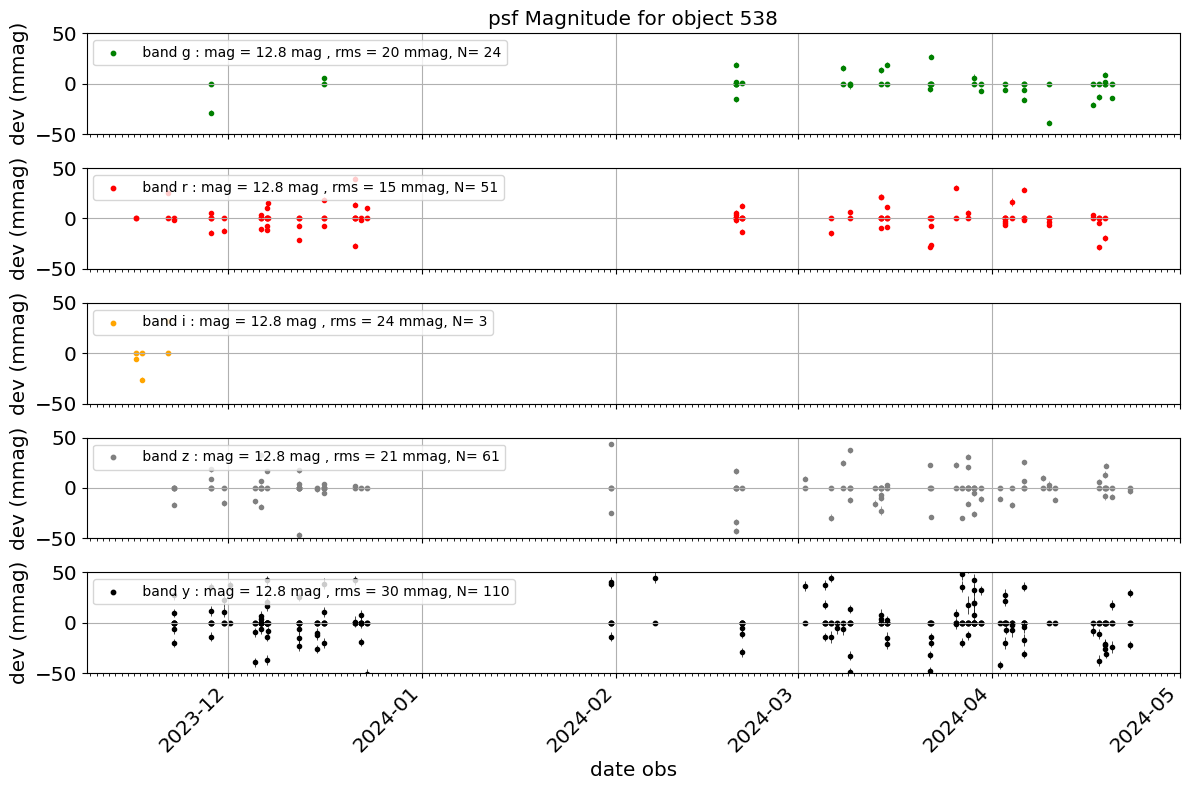

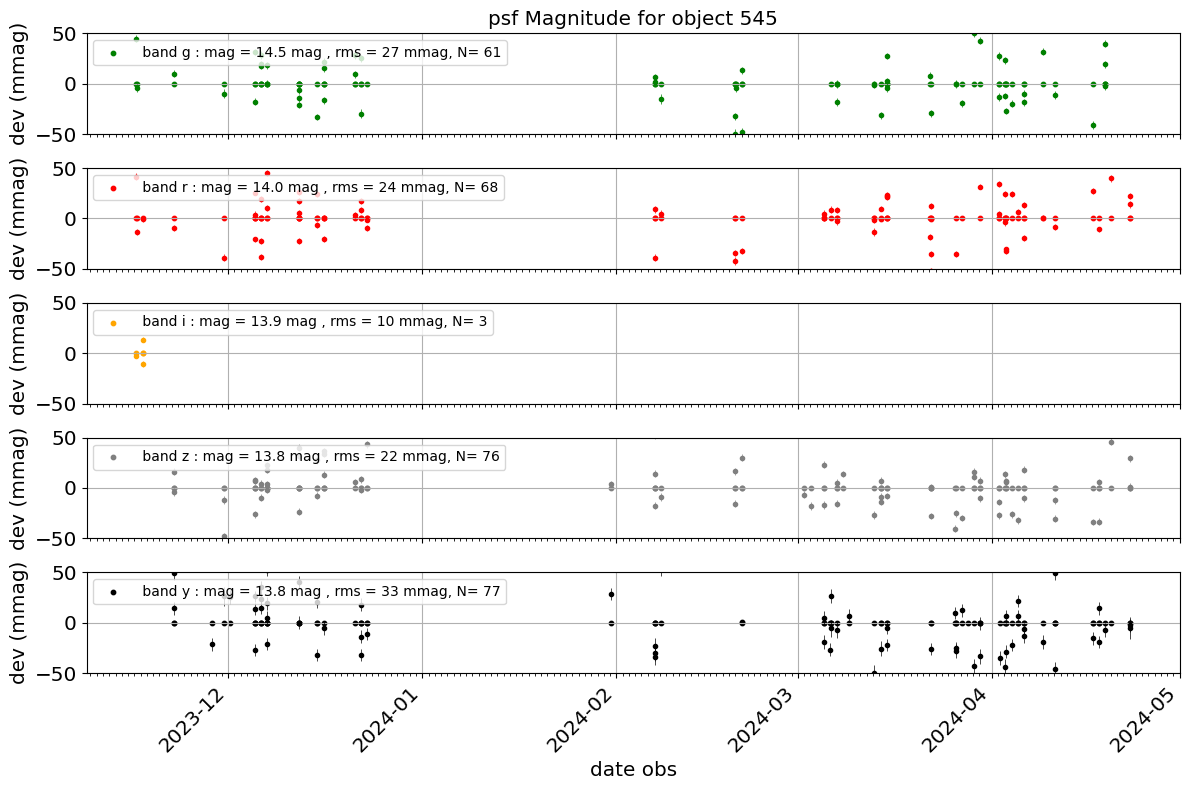

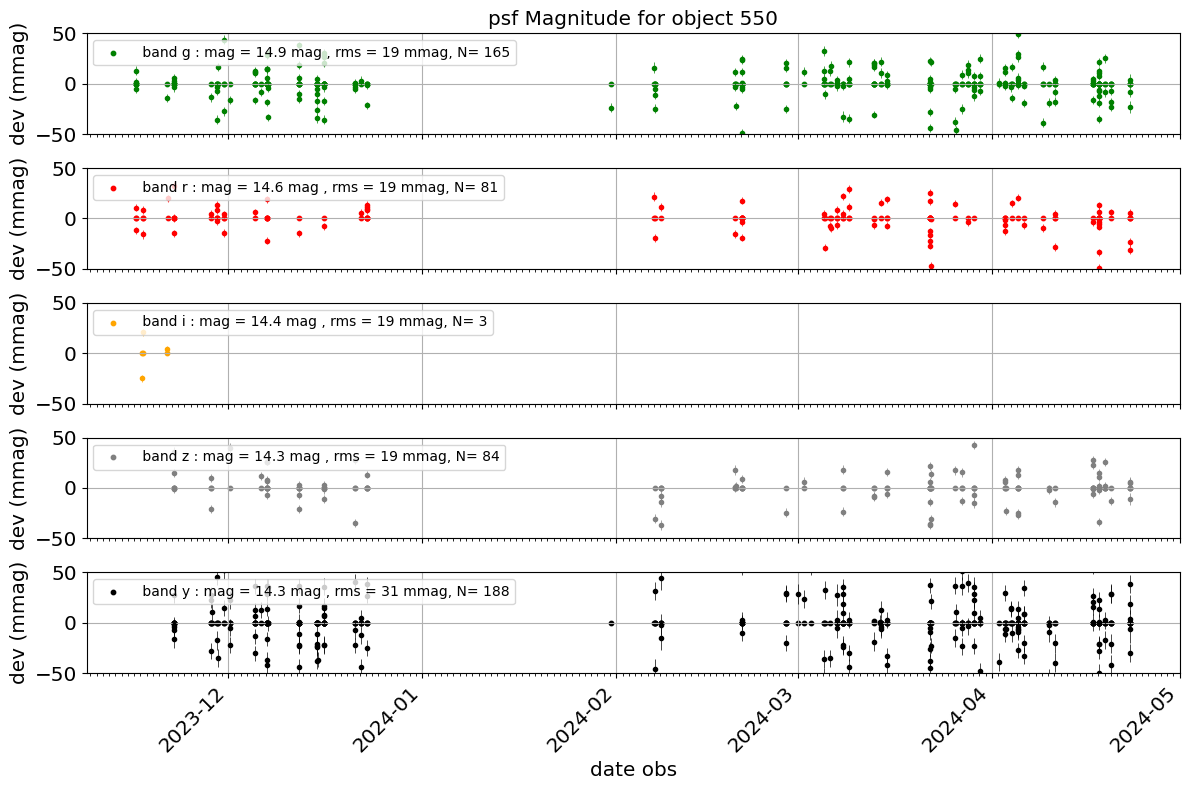

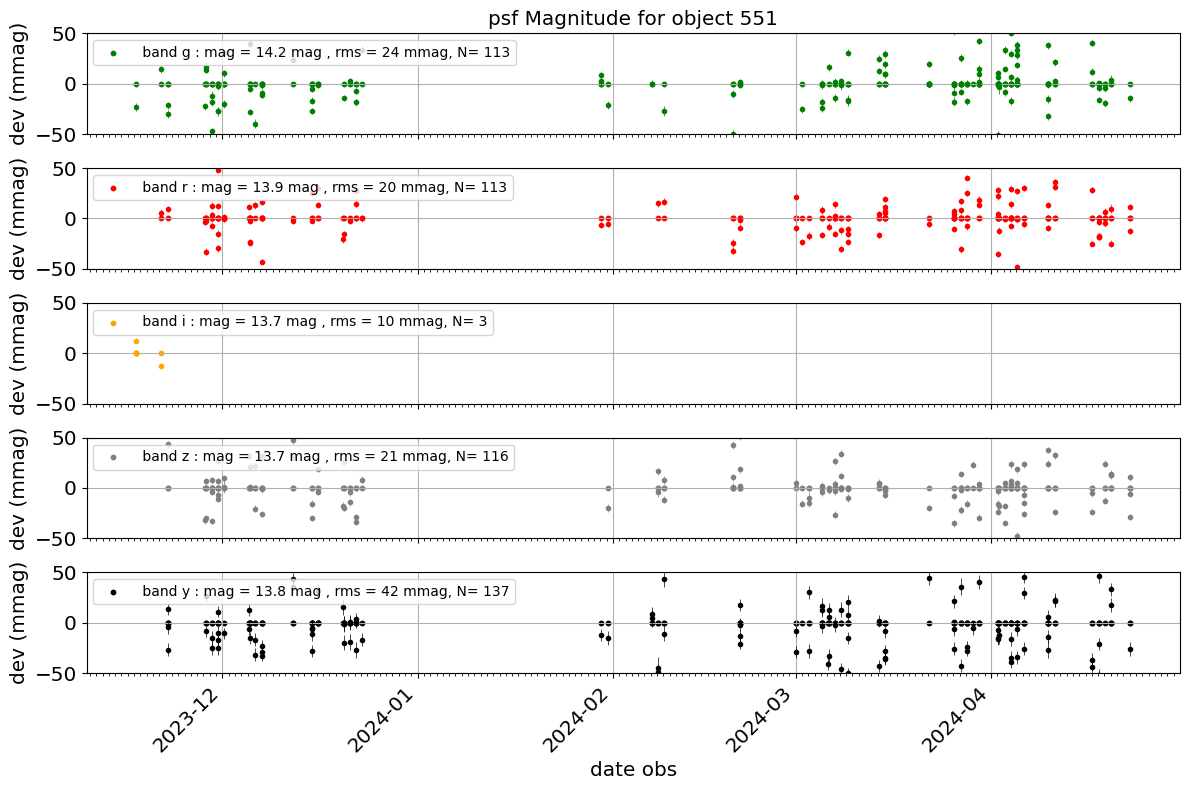

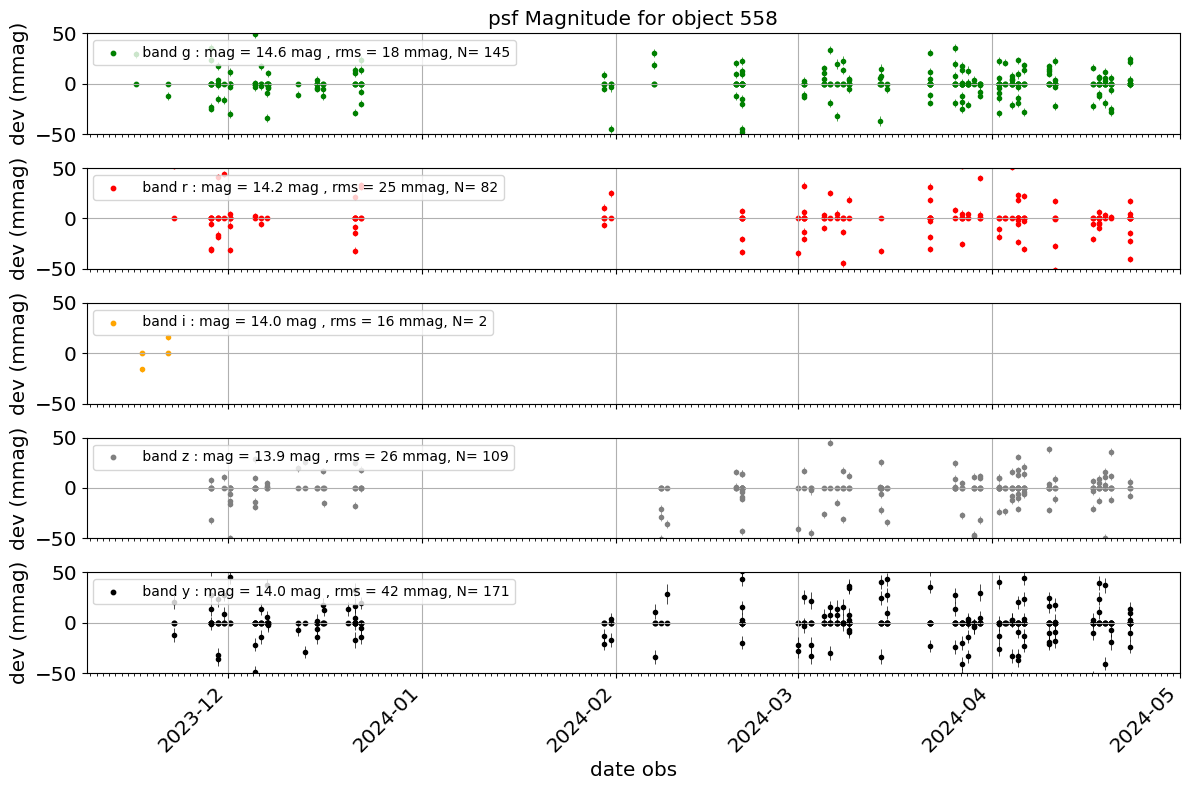

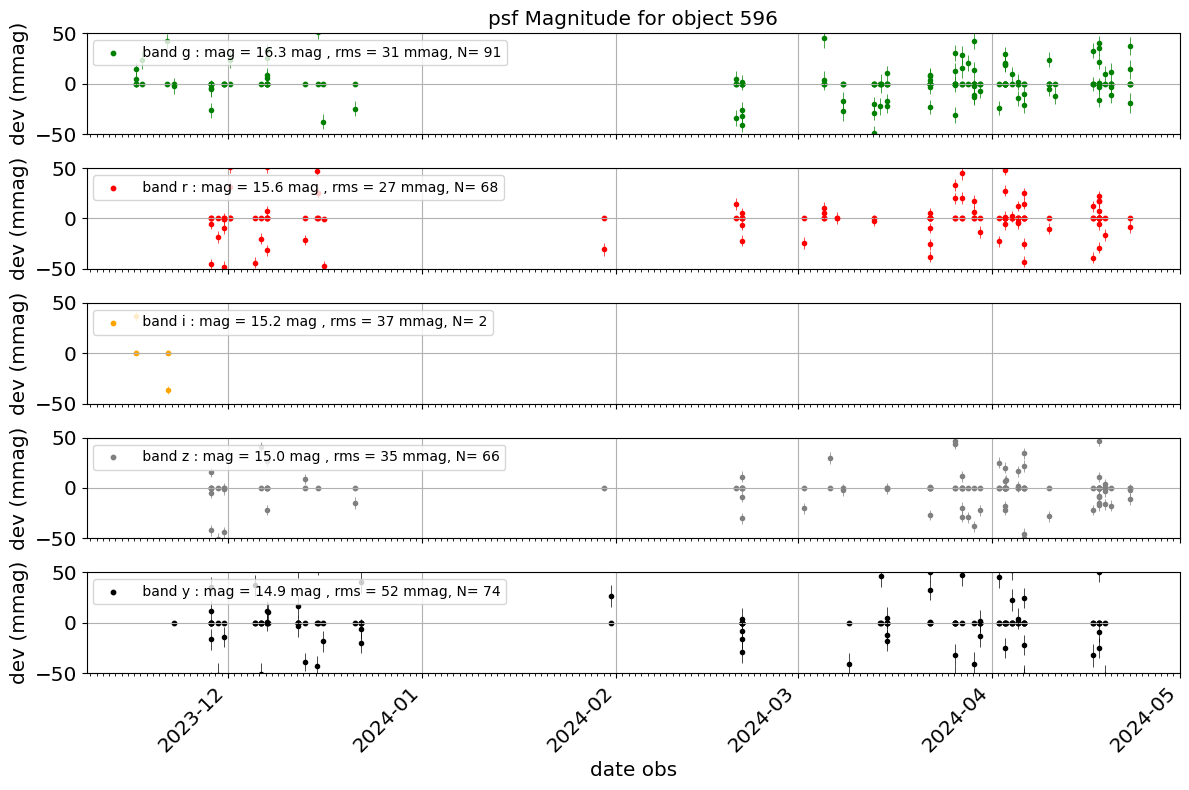

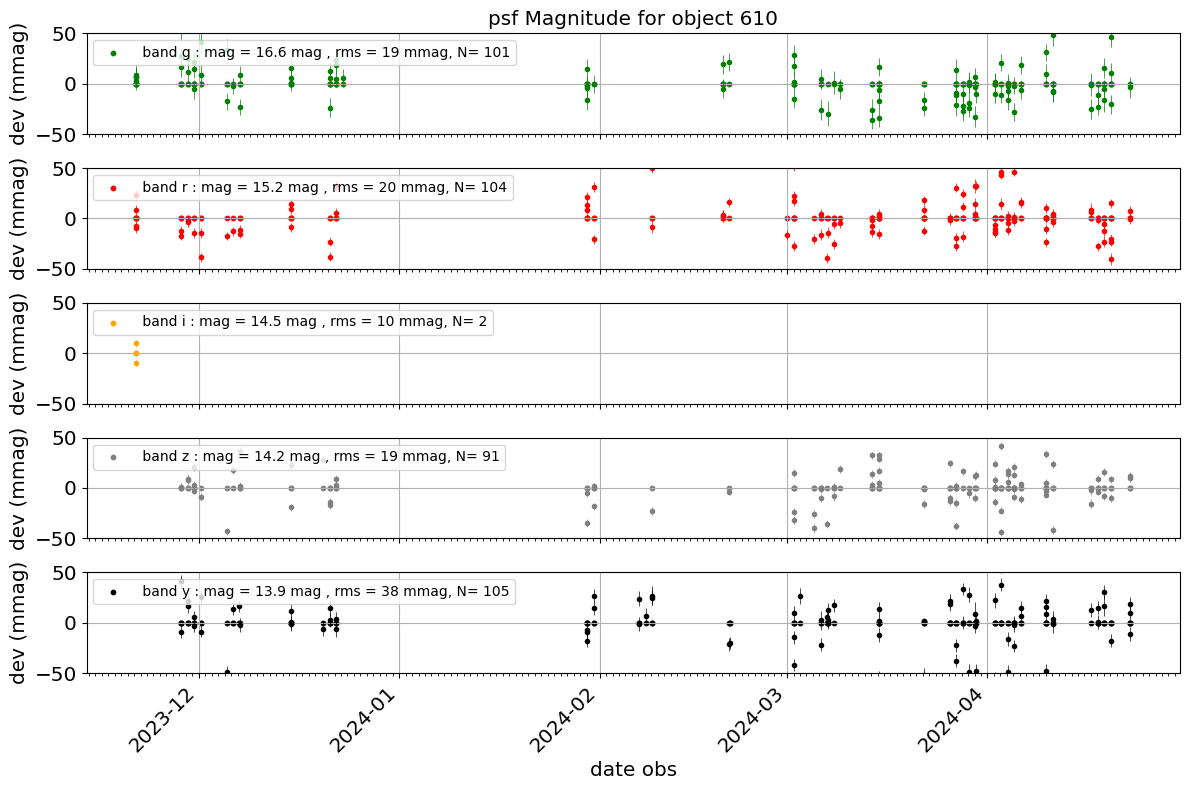

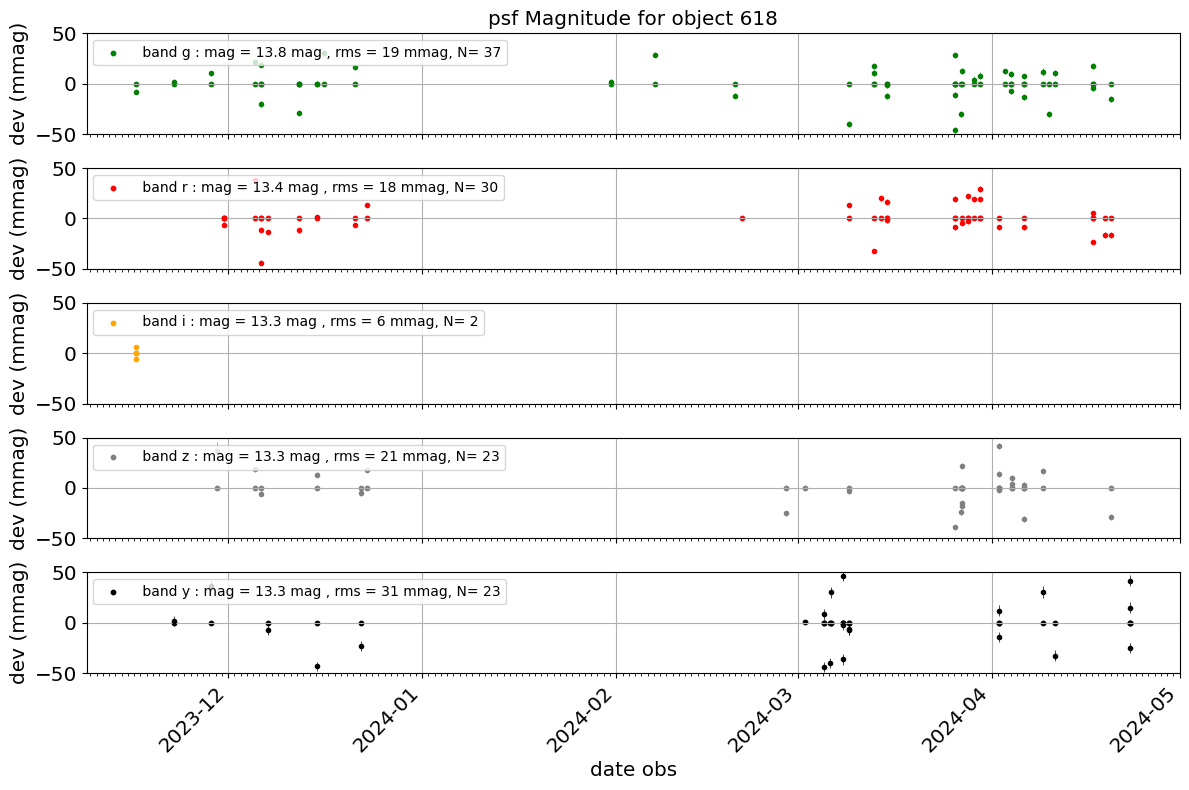

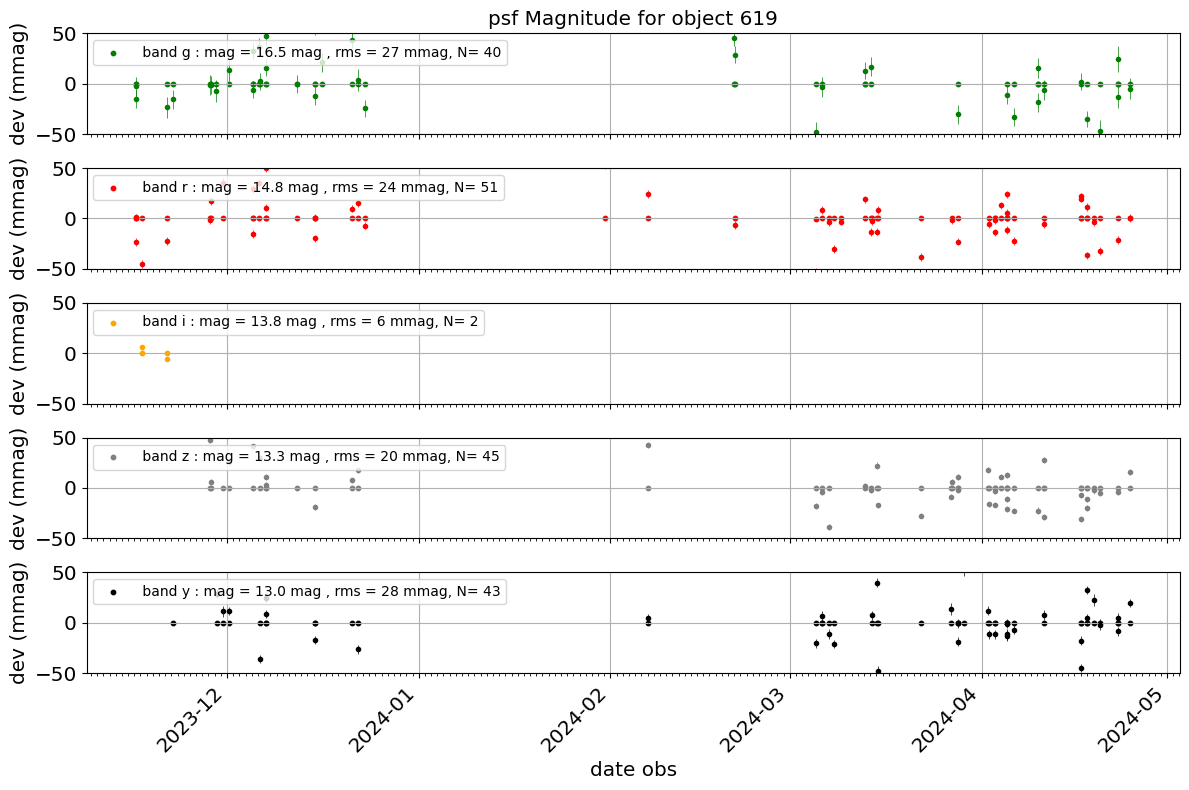

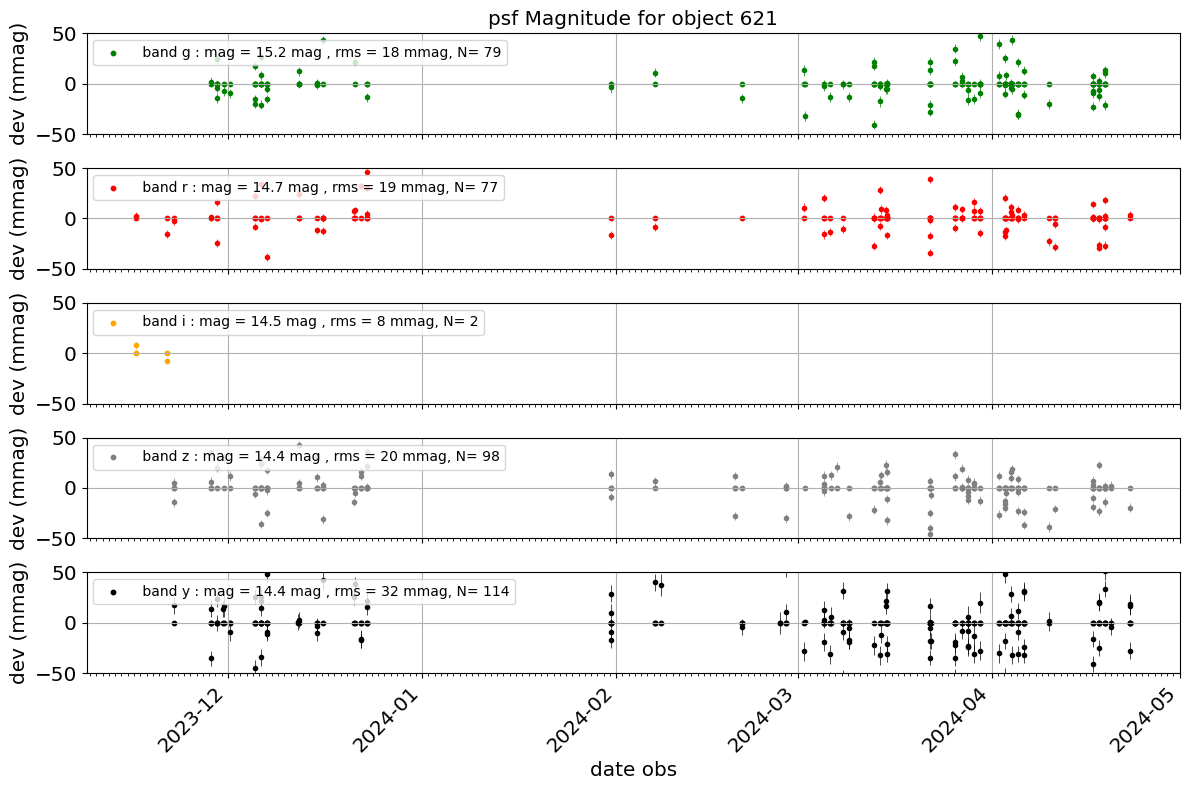

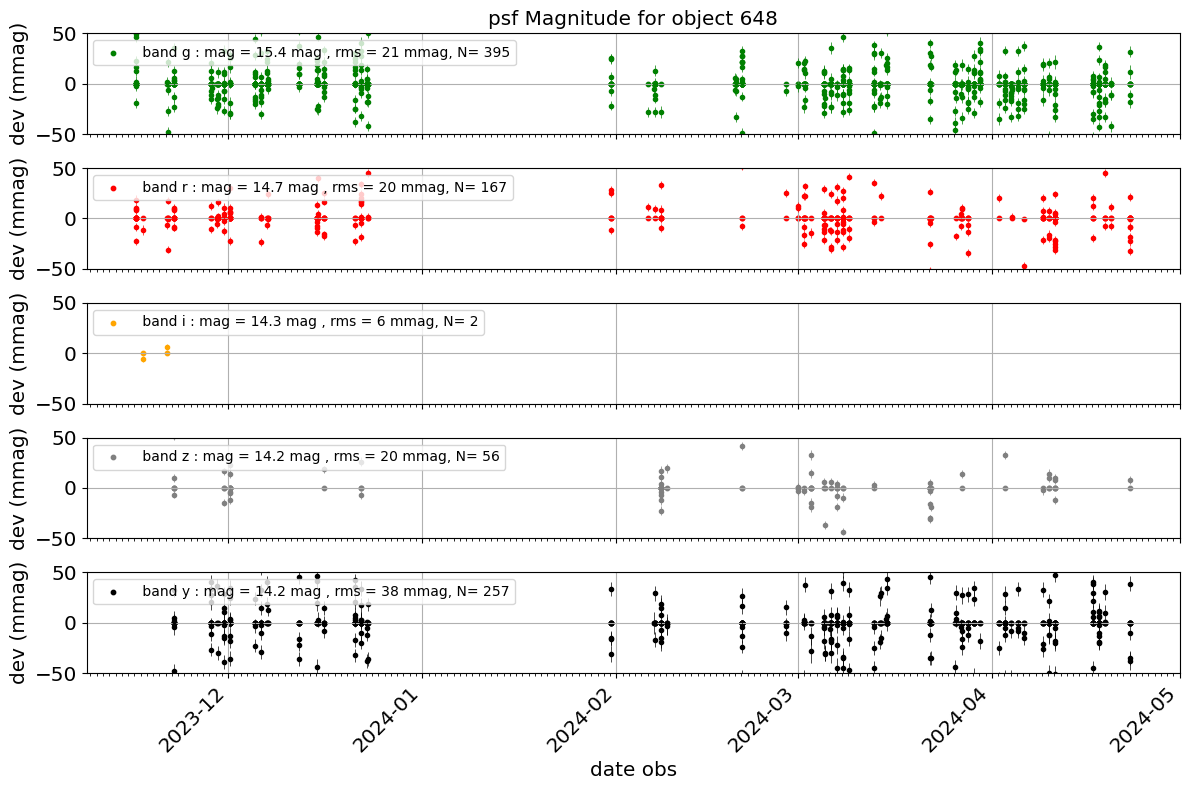

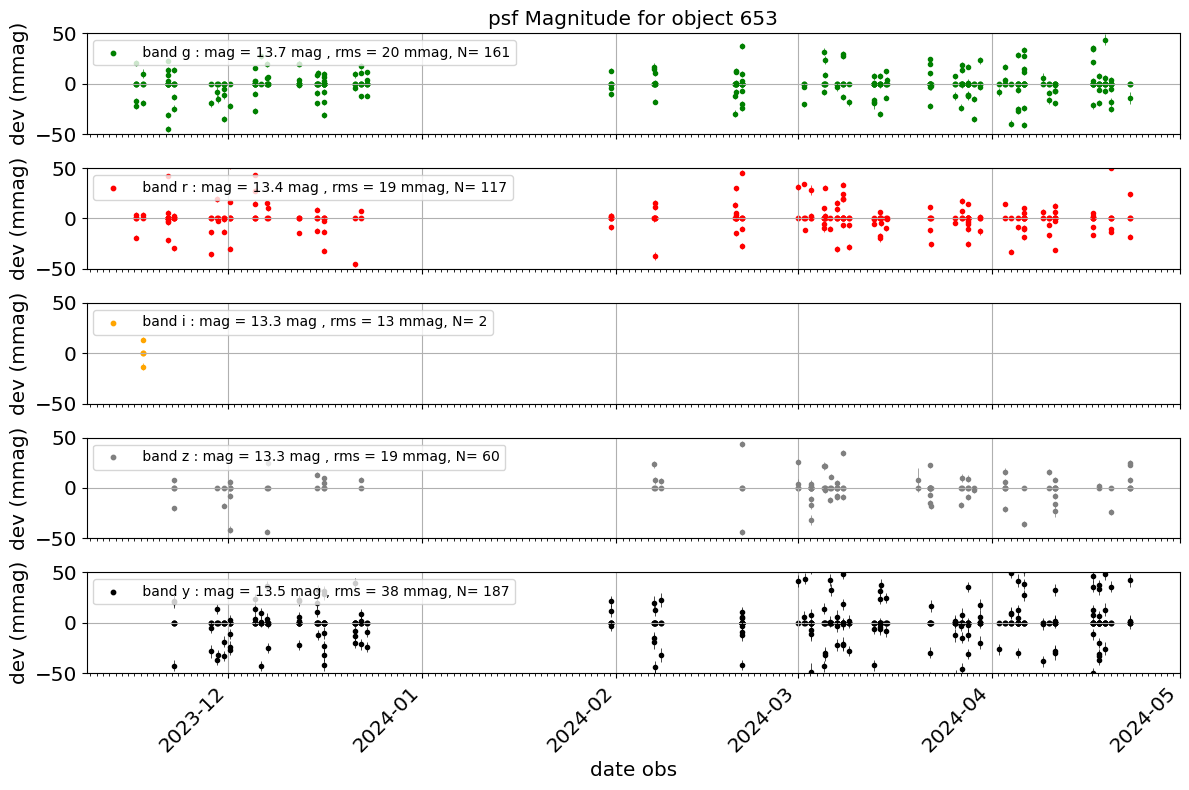

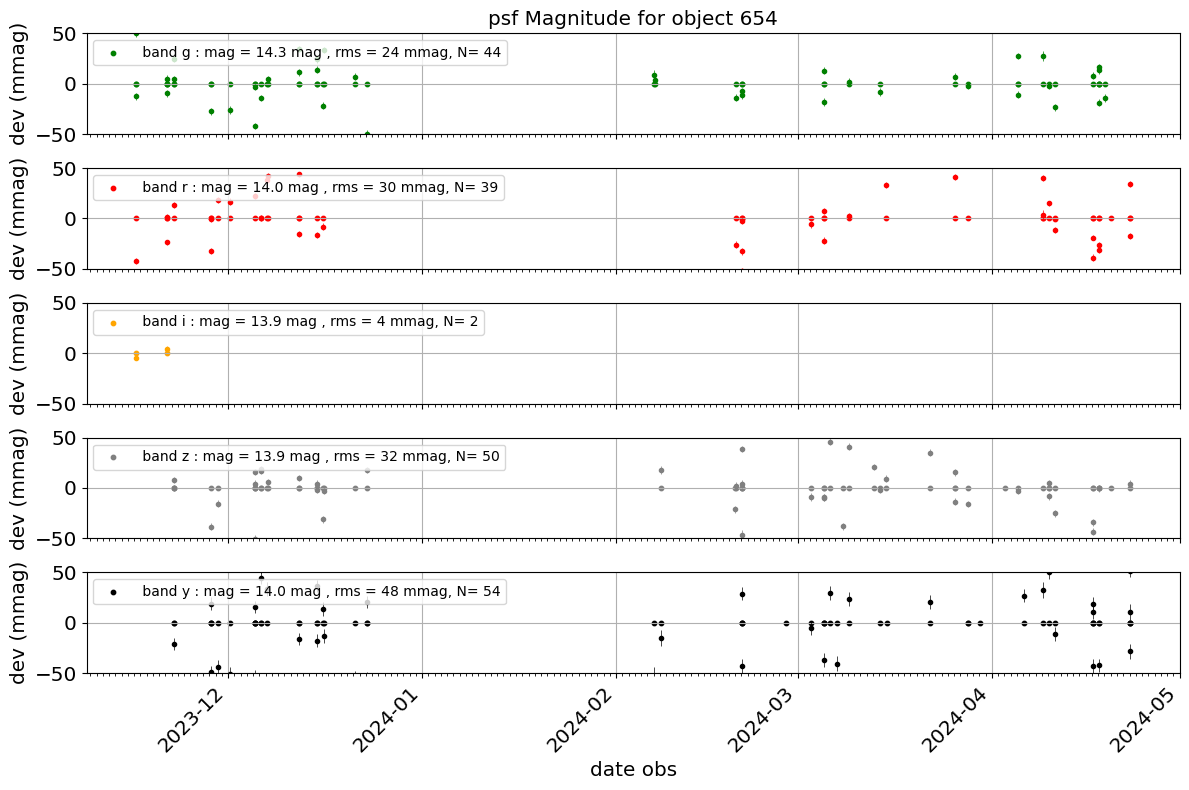

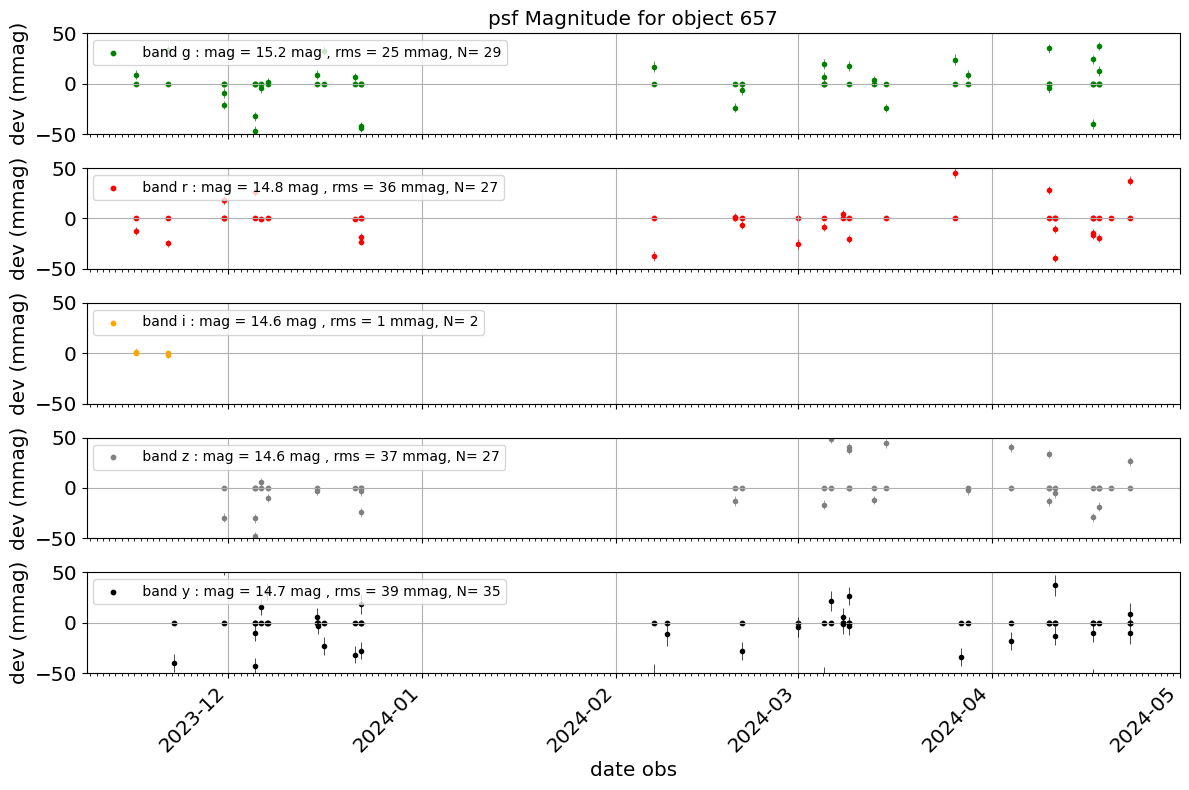

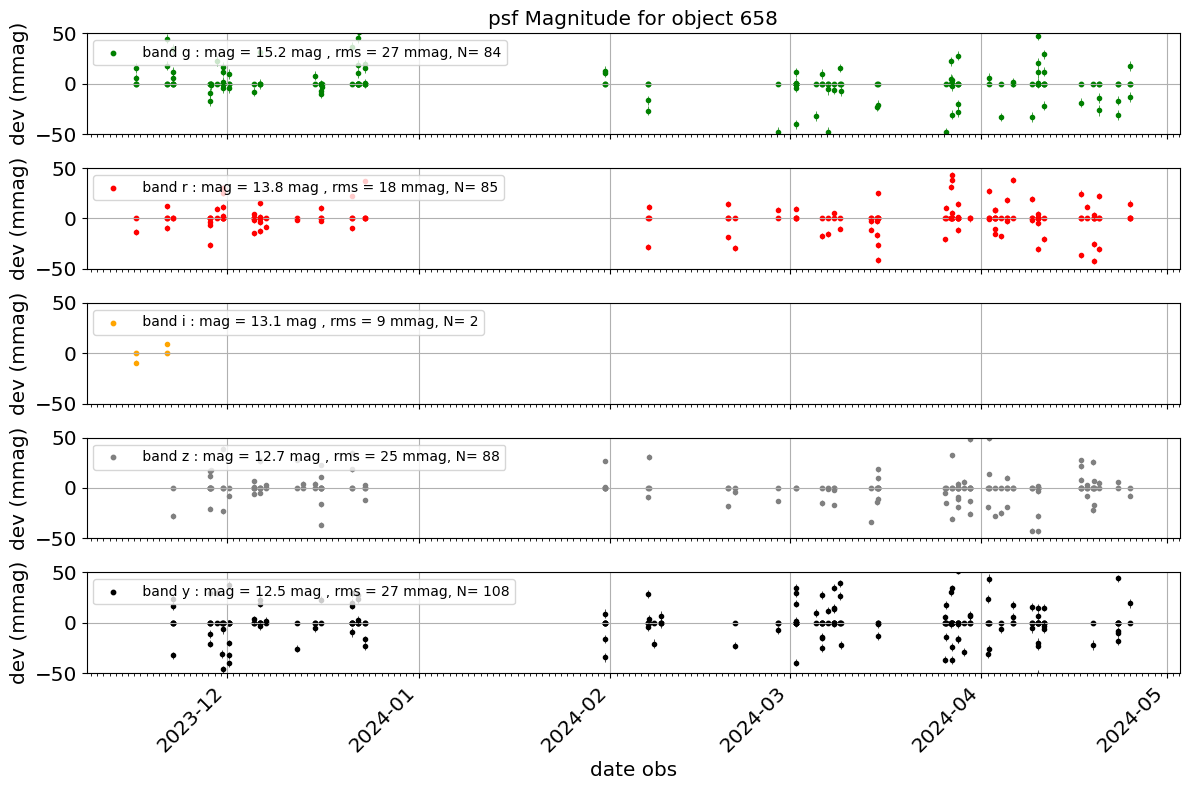

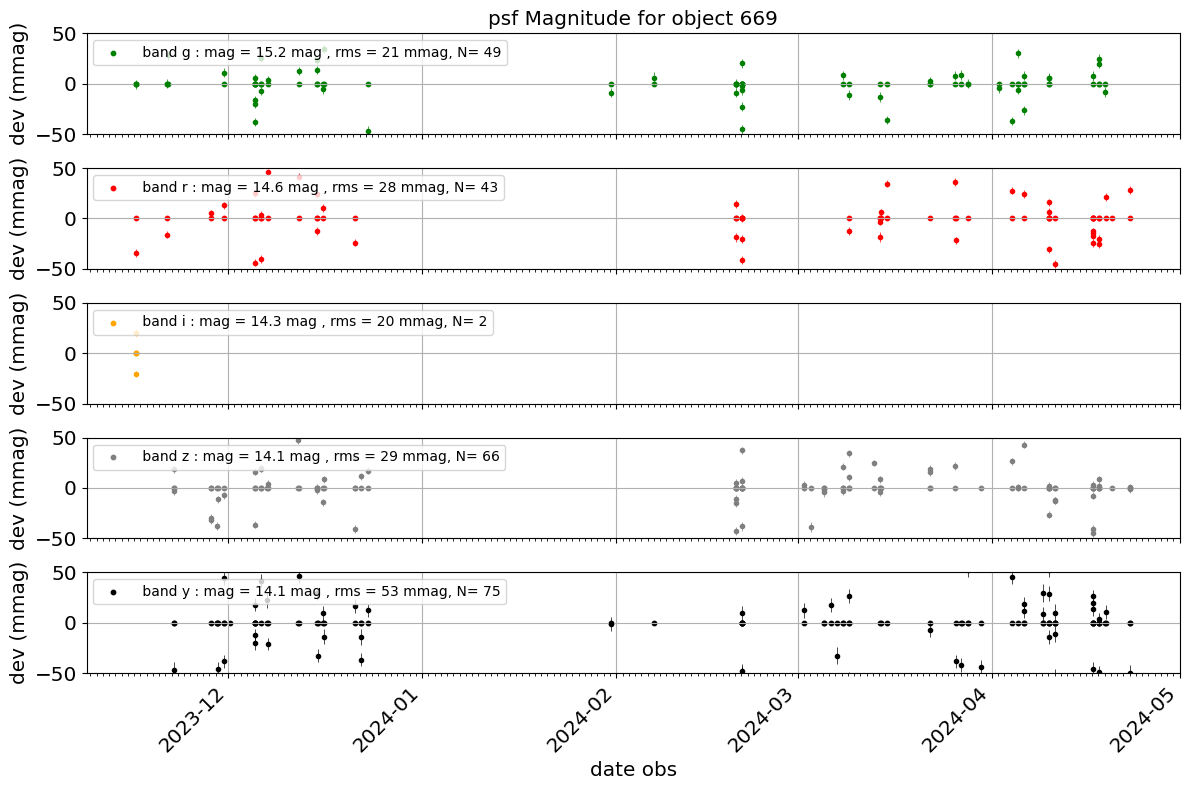

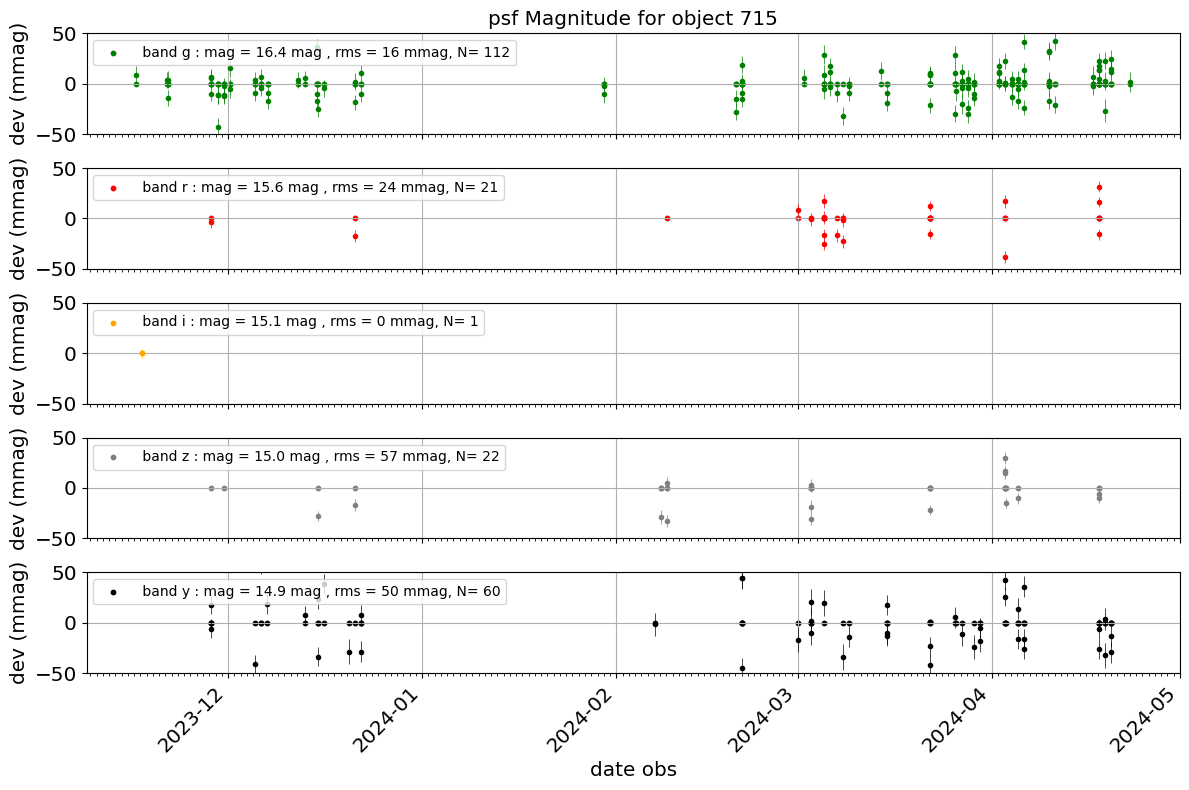

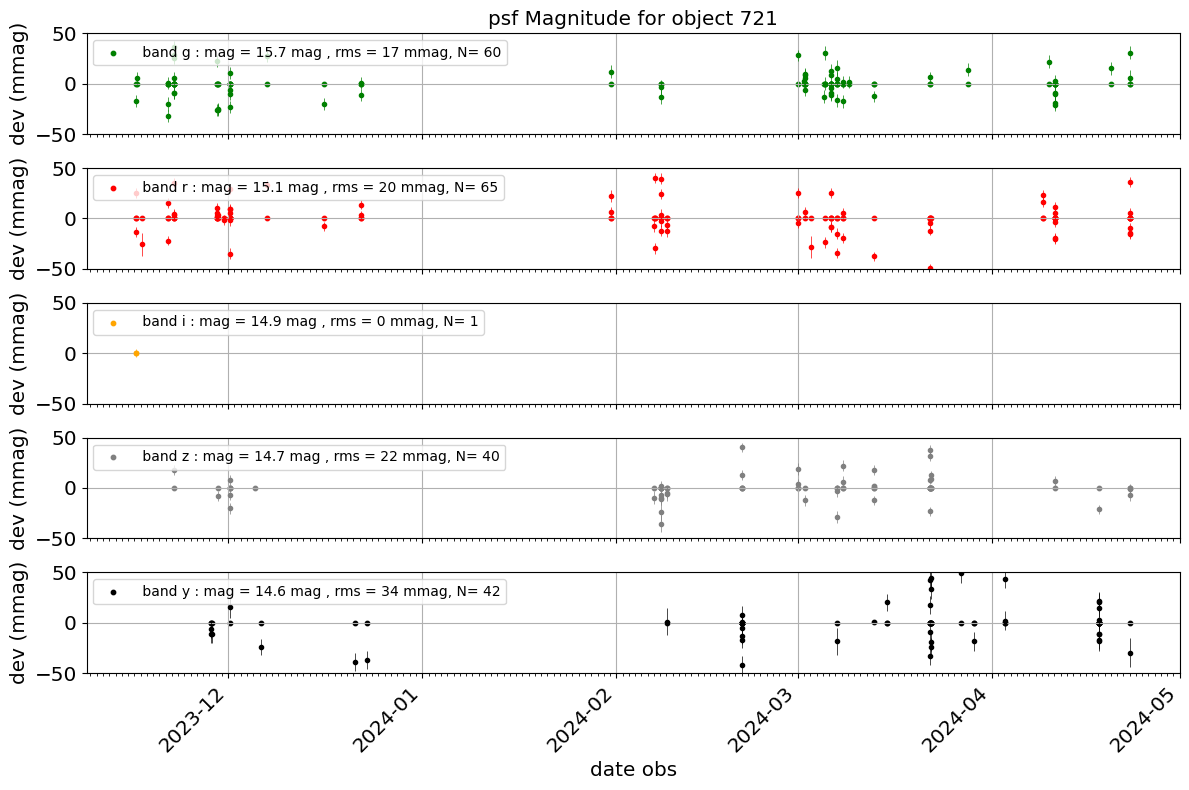

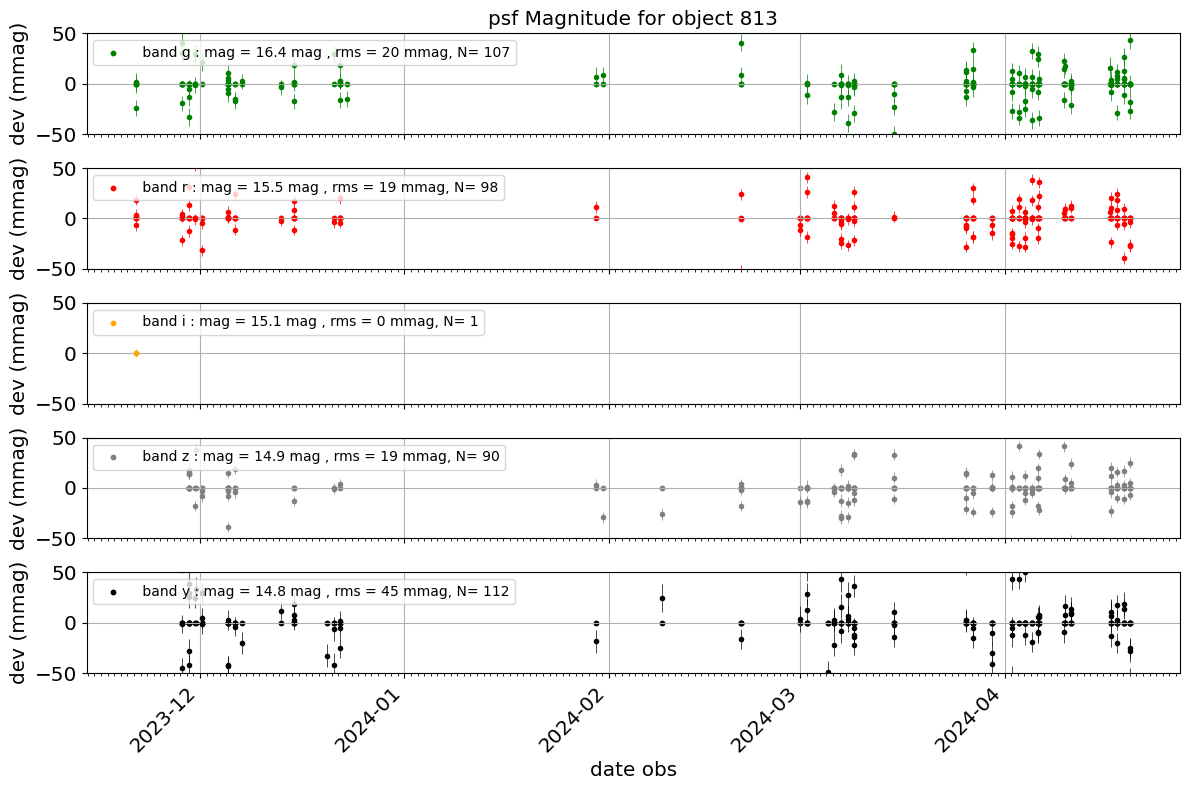

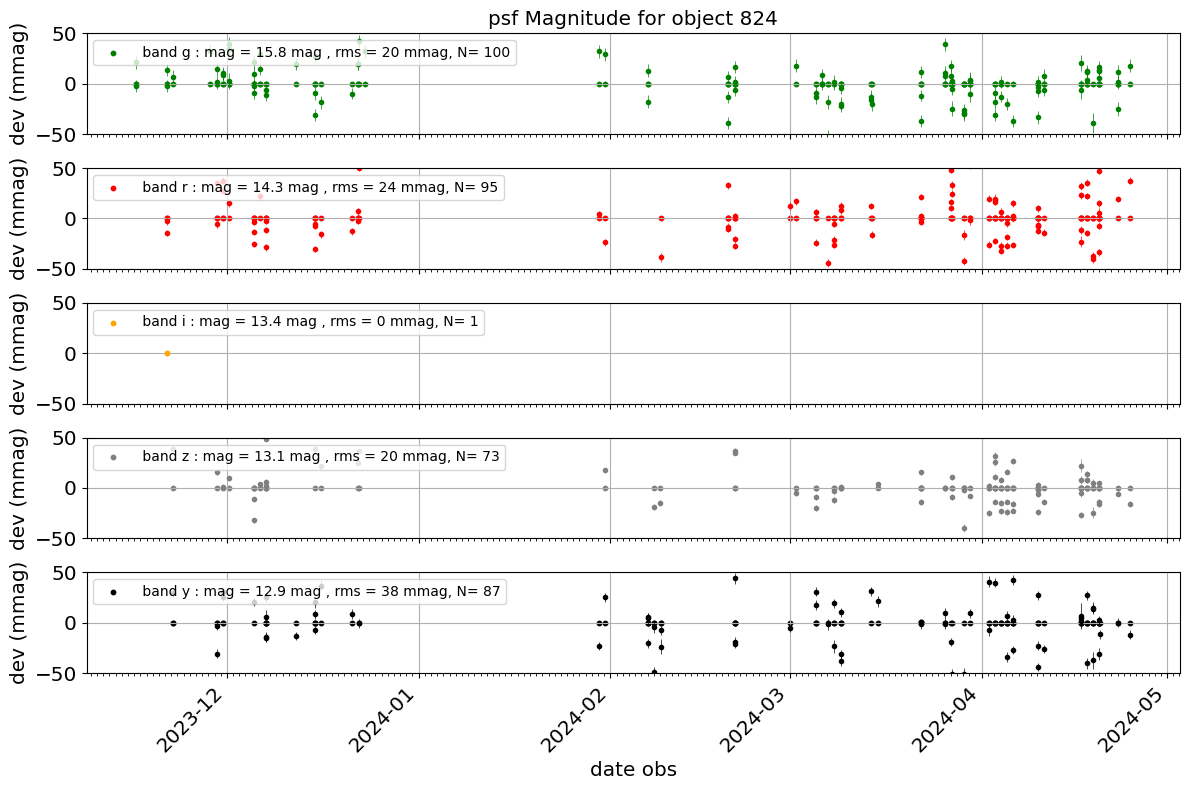

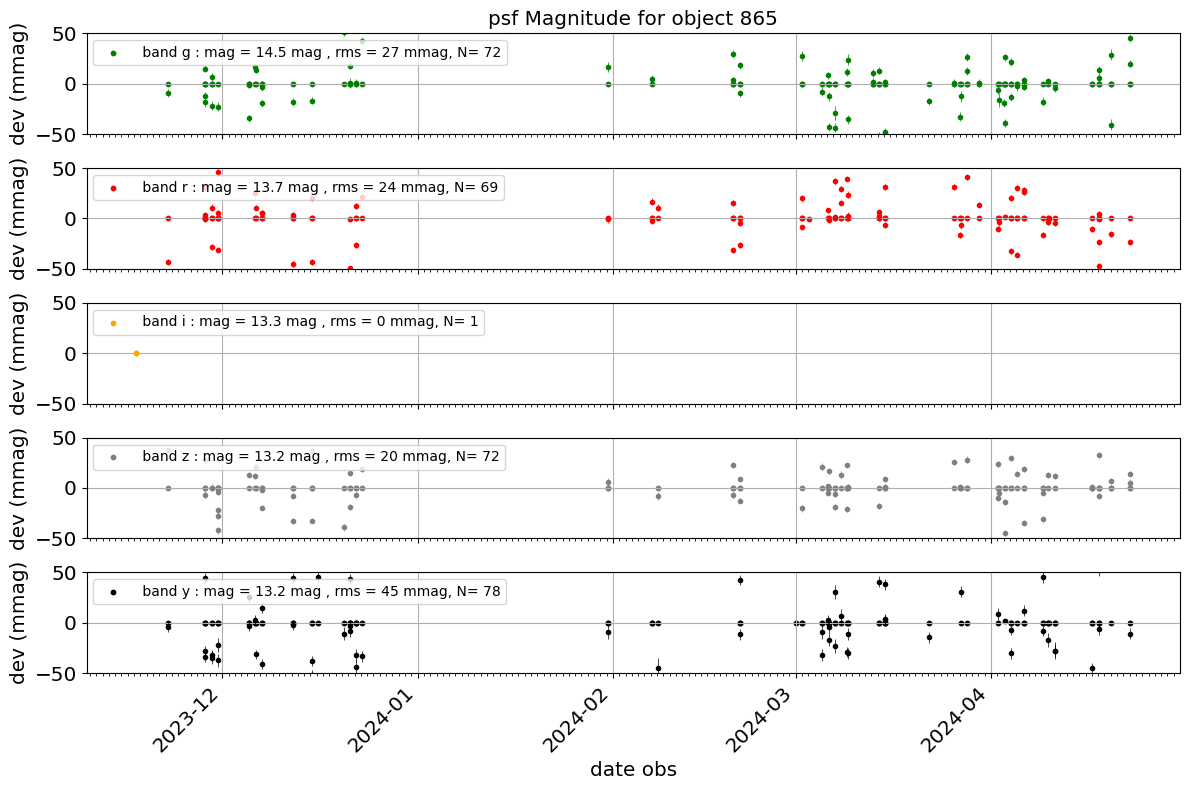

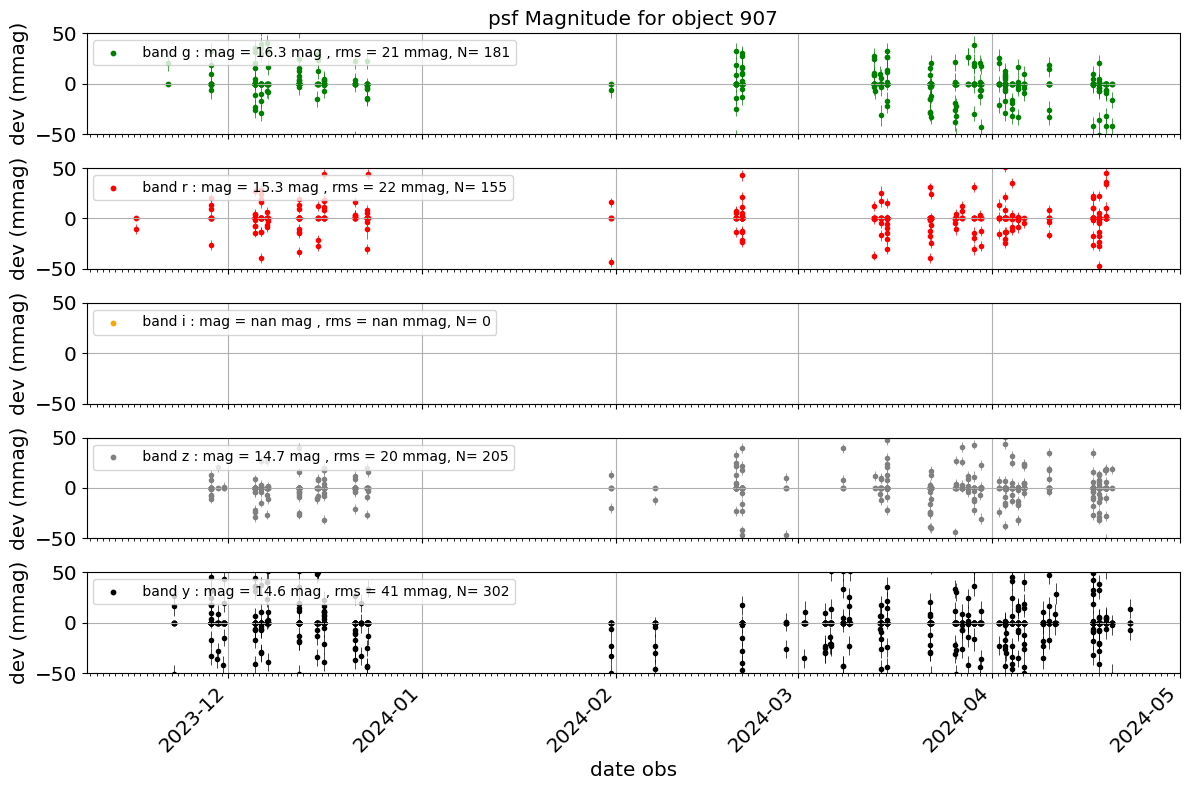

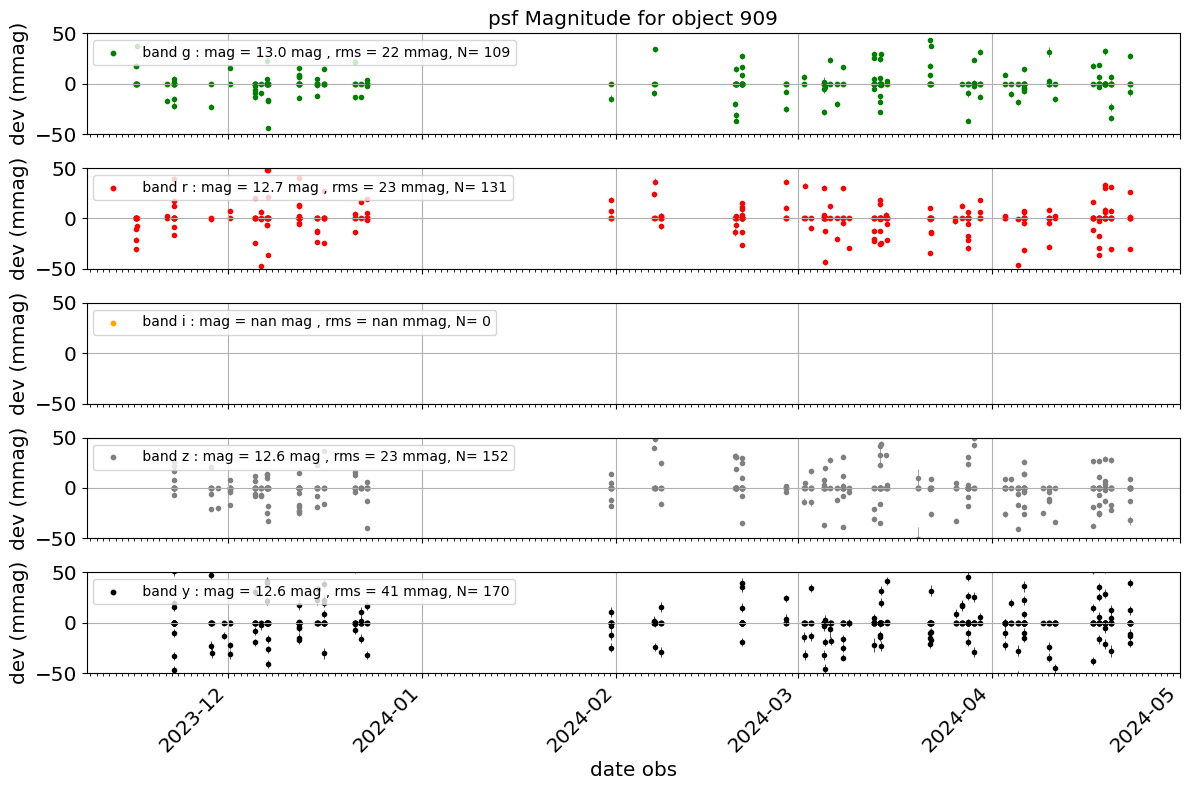

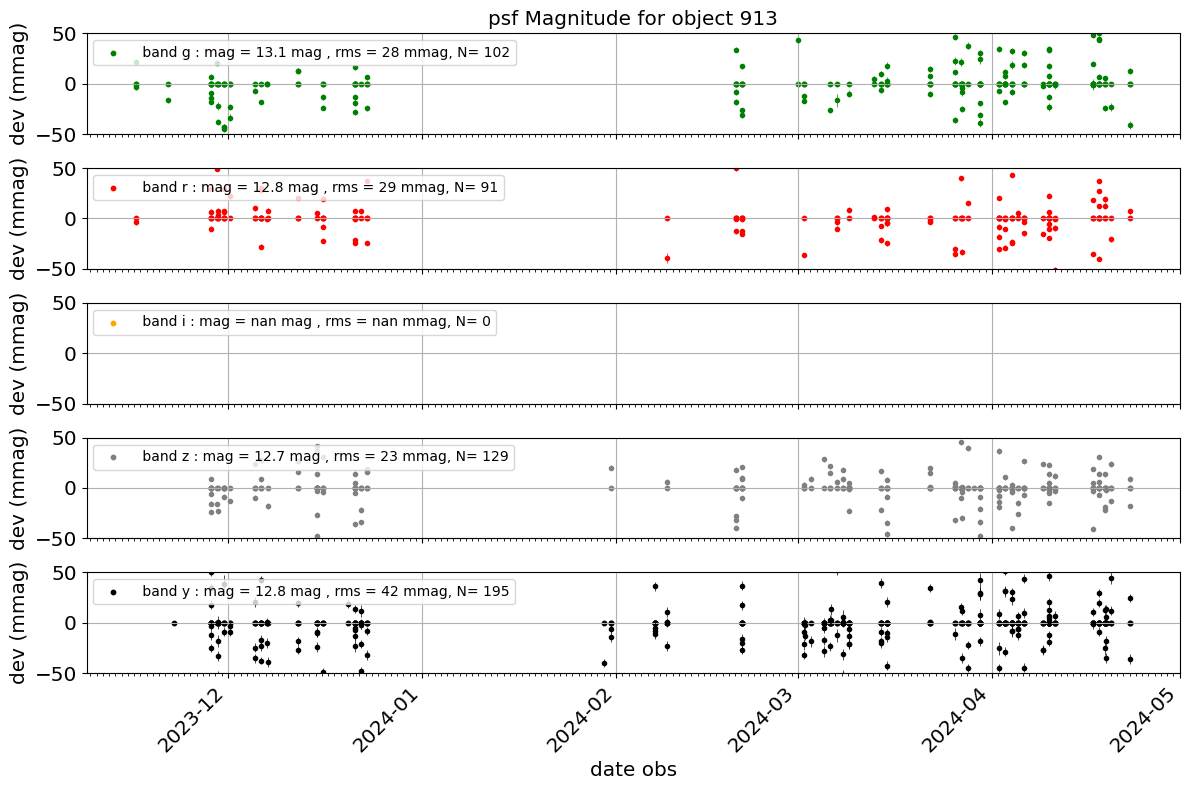

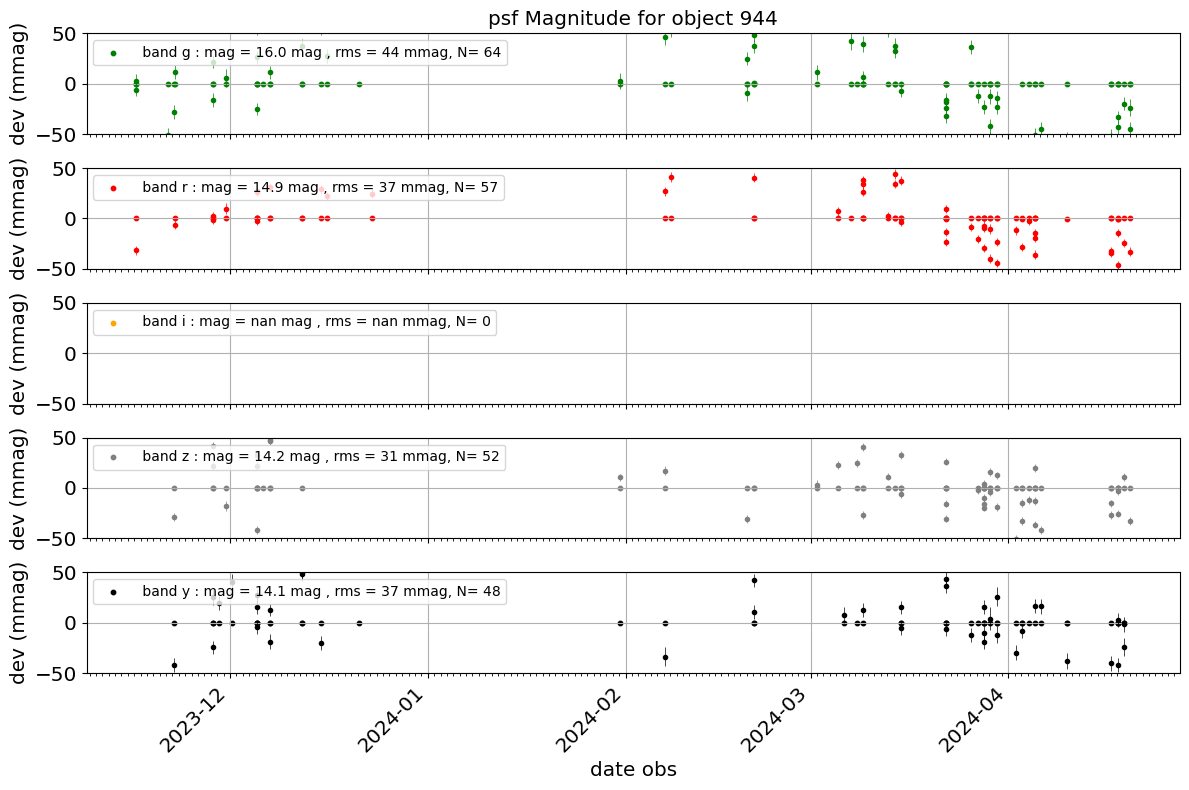

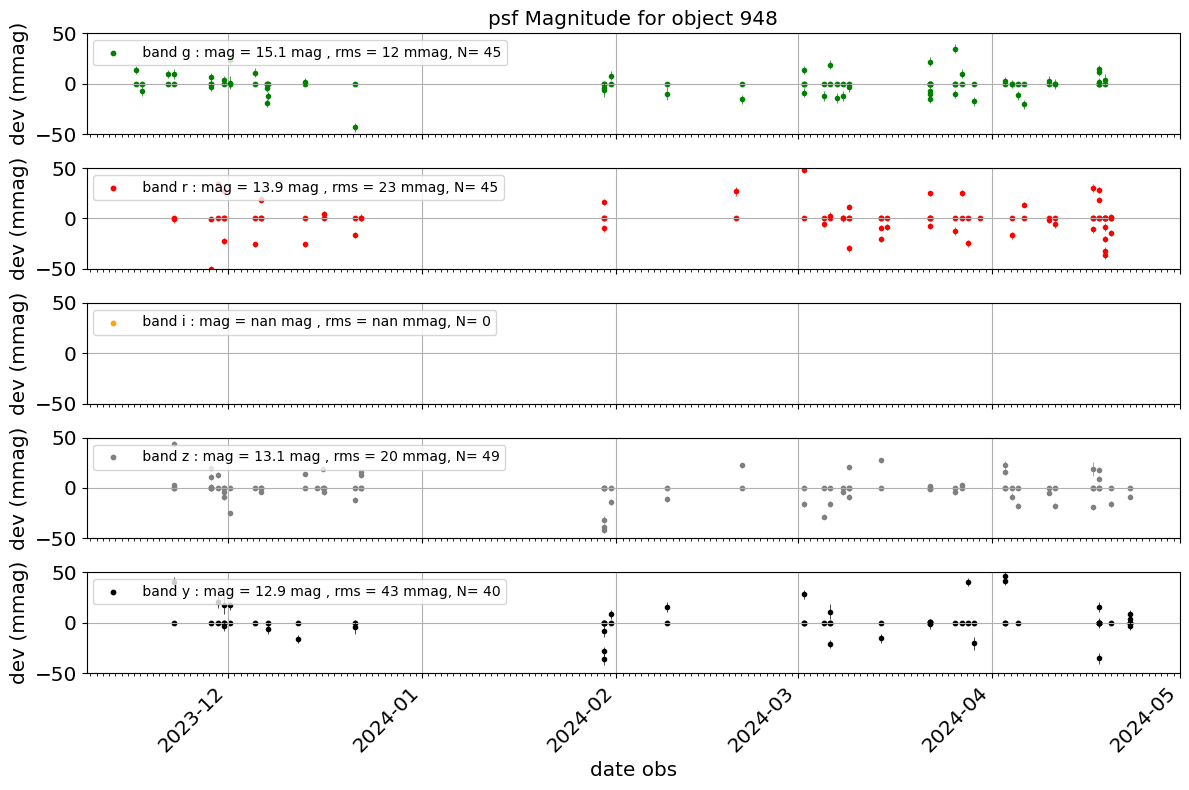

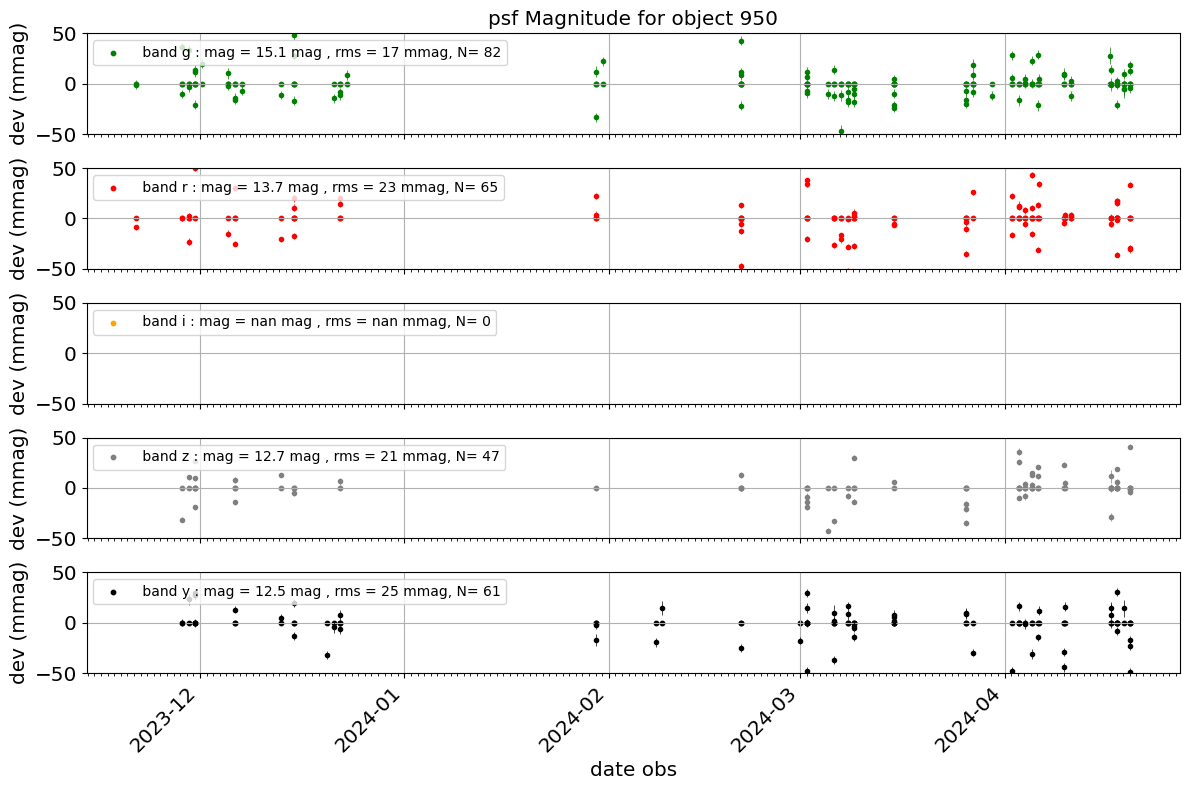

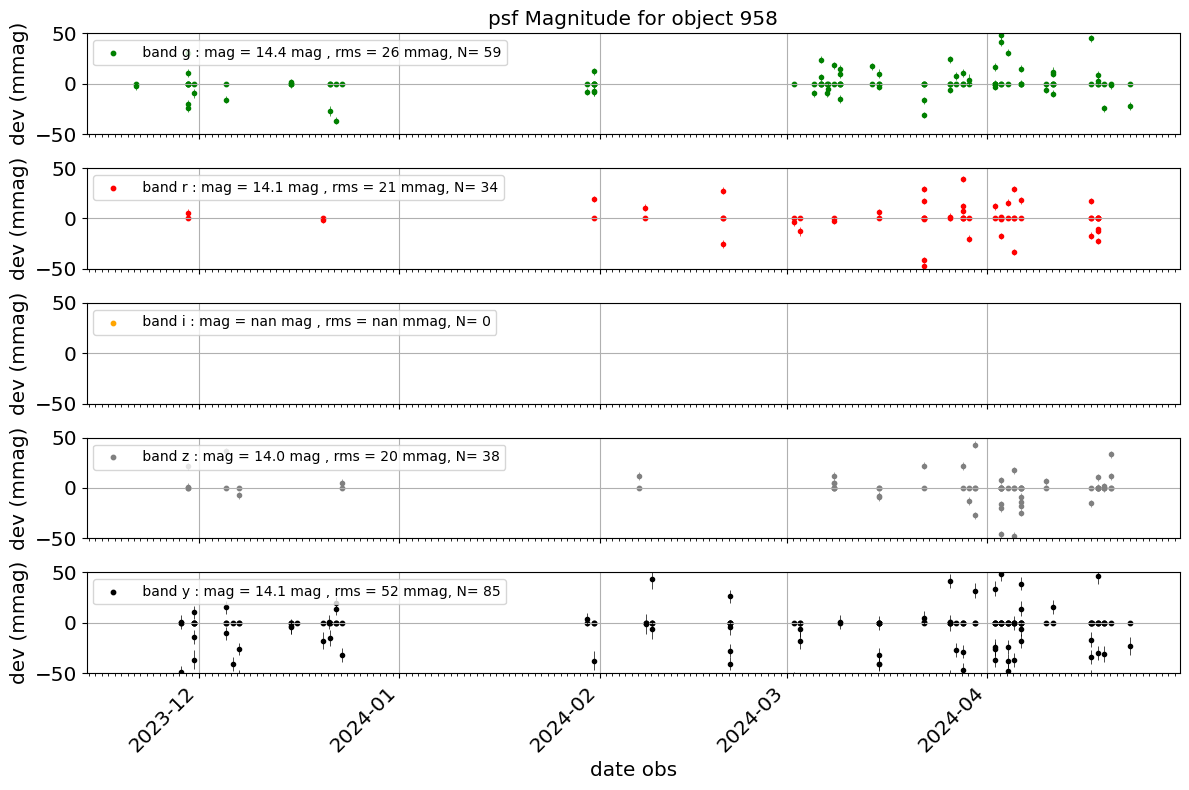

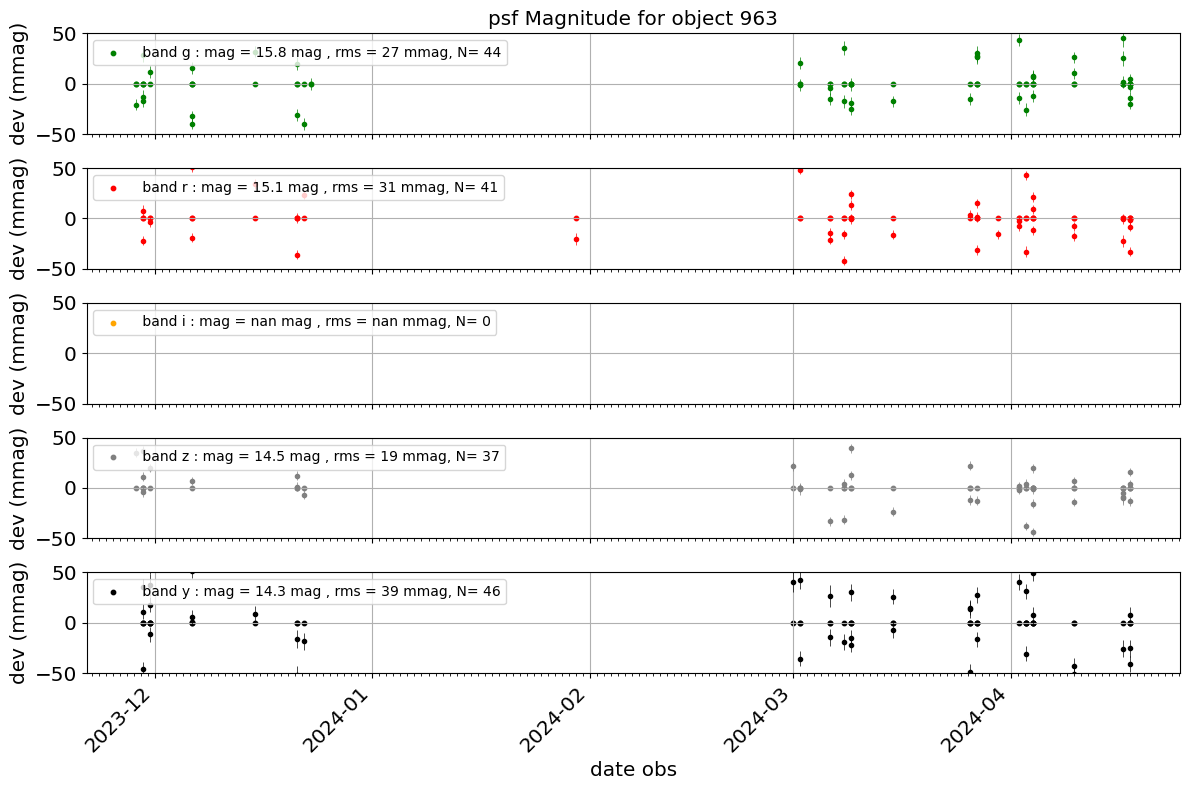

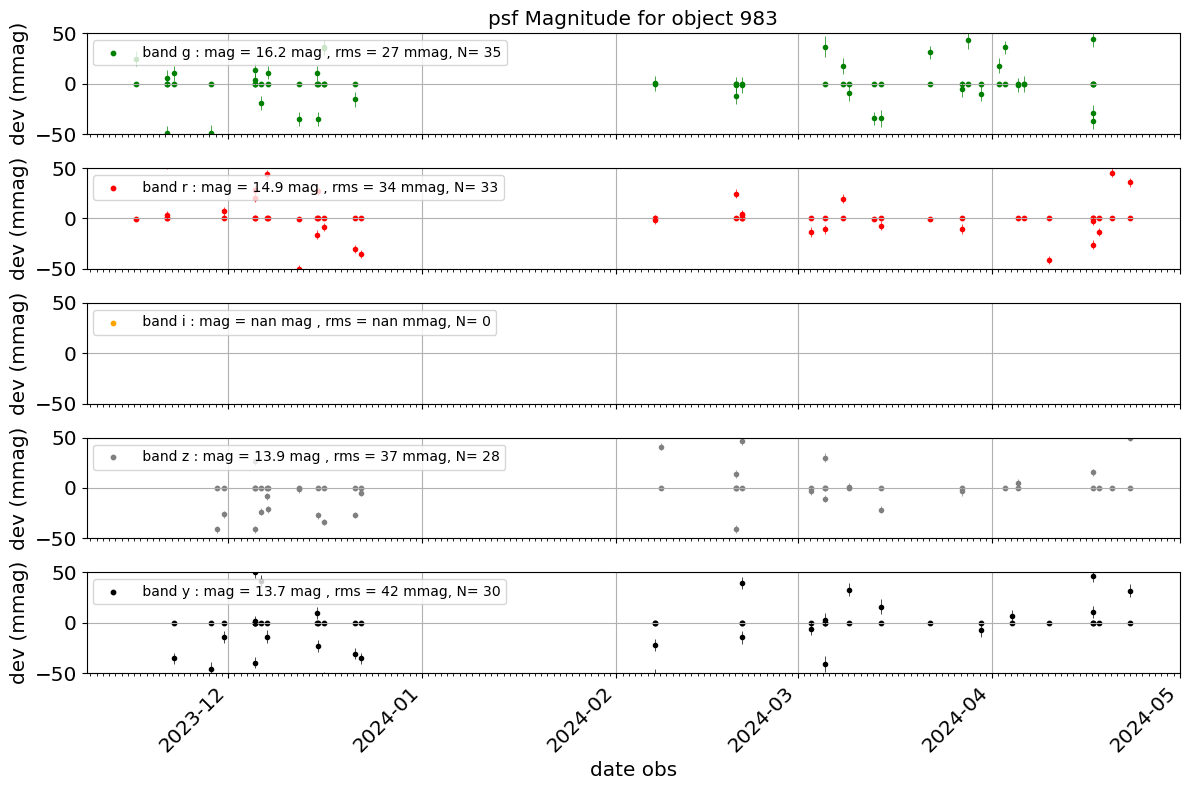

In [13]:
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 
colors = ["g","r","orange","grey","k"]

for idx,df in enumerate(all_df):
    obj_num = df.obj_index.unique()[0]
    
    df_filt = {}
    for idx_b,b in enumerate(["g","r","i","z","y"]):
        df_filt[b] = df[df.band == b]
        
        
    fig,axs = plt.subplots(5,1,figsize=(12,8),sharex=True)
    
    axes_flat = axs.flatten()
    for idx_b,b in enumerate(["g","r","i","z","y"]):
        X = pd.to_datetime(df_filt[b]['obsStart'].values)
        Y = df_filt[b]['psfMag'].values
        Yerr = df_filt[b]['psfMagErr'].values
        N = len(Y)
        clippedMeanMagArray = scipy.stats.sigmaclip(Y, low=3.0, high=3.0).clipped
        clippedMeanMag = np.mean(clippedMeanMagArray)
        clippedMeanMagErr = np.std(clippedMeanMagArray)/np.sqrt(len(clippedMeanMagArray))
        clippeErrorMagArray = scipy.stats.sigmaclip(Y-clippedMeanMag,low=3.0, high=3.0).clipped
        clippeErrorMagSigma = (np.sqrt(np.sum(clippeErrorMagArray**2))/np.sqrt(len(clippeErrorMagArray)))*1000.

        
        
        label = f" band {b} : mag = {clippedMeanMag:.1f} mag , rms = {clippeErrorMagSigma:.0f} mmag, N= {N}"
        axes_flat[idx_b].errorbar(X,(Y-clippedMeanMag)*1000,yerr=Yerr*1000,fmt='.',lw=0.5,c=colors[idx_b],ecolor=colors[idx_b]) 
        axes_flat[idx_b].scatter(X,Y-clippedMeanMag,marker='o',s=10,c=colors[idx_b],label=label) 
        axes_flat[idx_b].xaxis.set_major_locator(month_locator) # Locator for major axis only.
        axes_flat[idx_b].xaxis.set_minor_locator(day_locator)
        axes_flat[idx_b].xaxis.set_major_formatter(year_month_formatter)
        axes_flat[idx_b].set_xticks(axes_flat[idx_b].get_xticks(), axes_flat[idx_b].get_xticklabels(), rotation=45, ha='right')
        axes_flat[idx_b].grid()
        if idx_b == 0:
            axes_flat[idx_b].set_title(f"psf Magnitude for object {obj_num}")
        elif idx_b == 4:
            axes_flat[idx_b].set_xlabel("date obs") 
        axes_flat[idx_b].set_ylabel("dev (mmag)") 
        axes_flat[idx_b].legend(loc="upper left")
        axes_flat[idx_b].set_ylim(-50,50)
    plt.tight_layout()
    plt.show()
    
  
    
    

In [14]:
Y

array([13.64249939, 13.69246461, 13.66318243, 13.68447071, 13.69077765,
       13.64518121, 13.67622348, 13.68429986, 13.71437473, 13.73123463,
       13.66776513, 13.65706199, 13.78988195, 13.70003888, 13.65873166,
       13.7482978 , 13.65271121, 13.70151065, 13.67502837, 13.6838716 ,
       13.73801451, 13.74463156, 13.70905125, 13.70818249, 13.63678427,
       13.73972299, 13.66299392, 13.73014205, 13.70532886, 13.8170175 ])